Periodo 1 descartado por amplitud cero
Periodo 3 descartado por amplitud cero


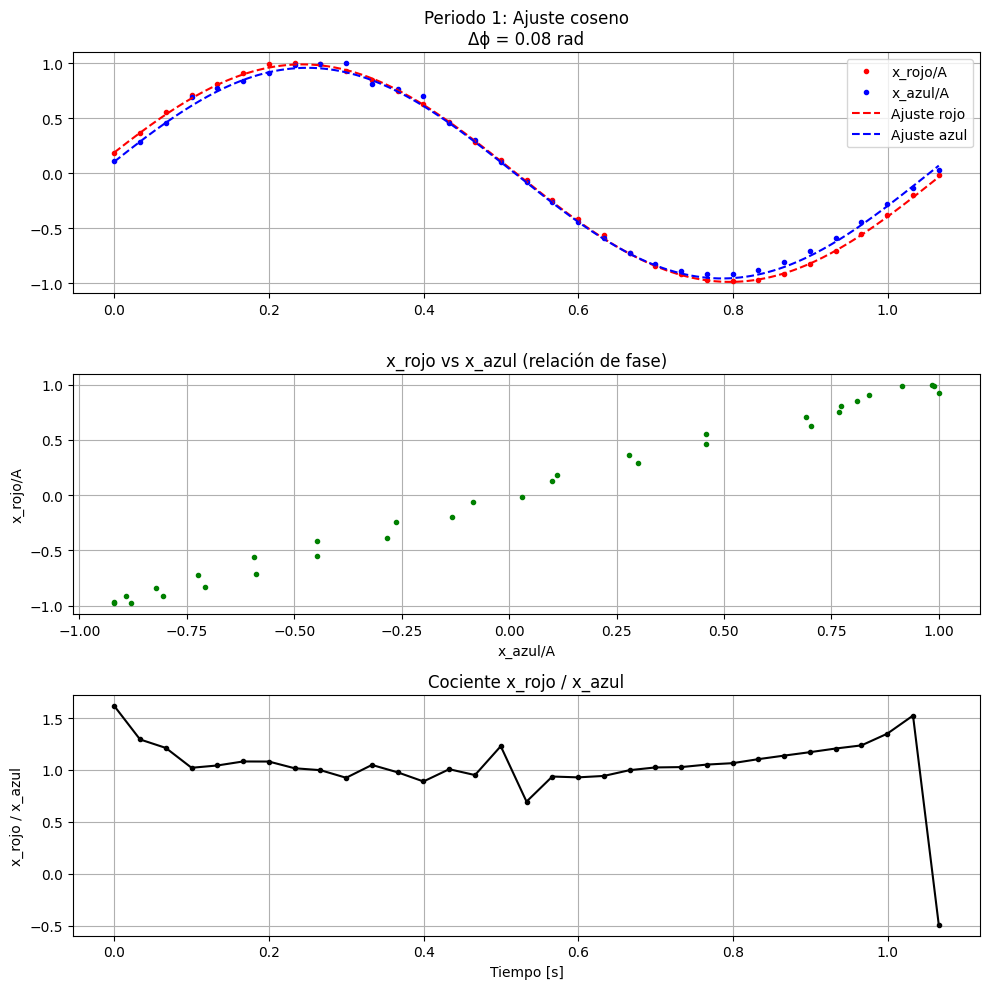

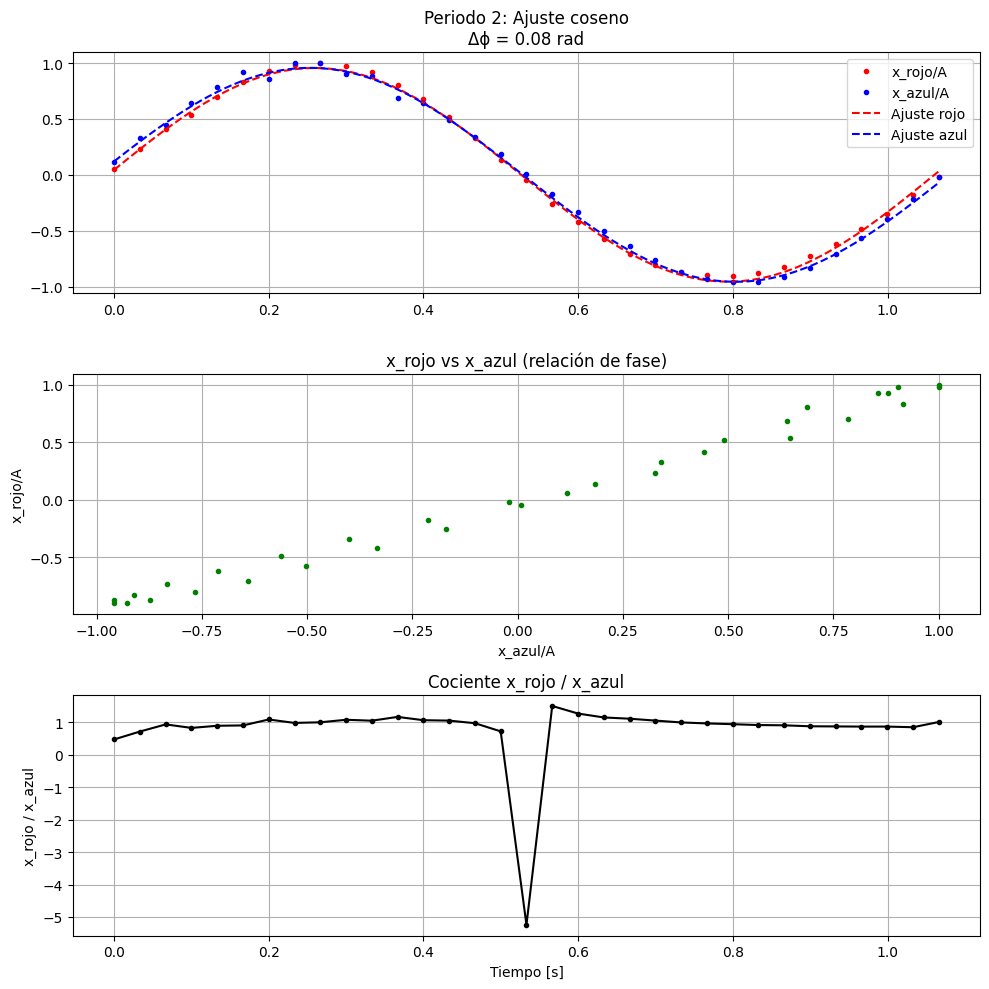

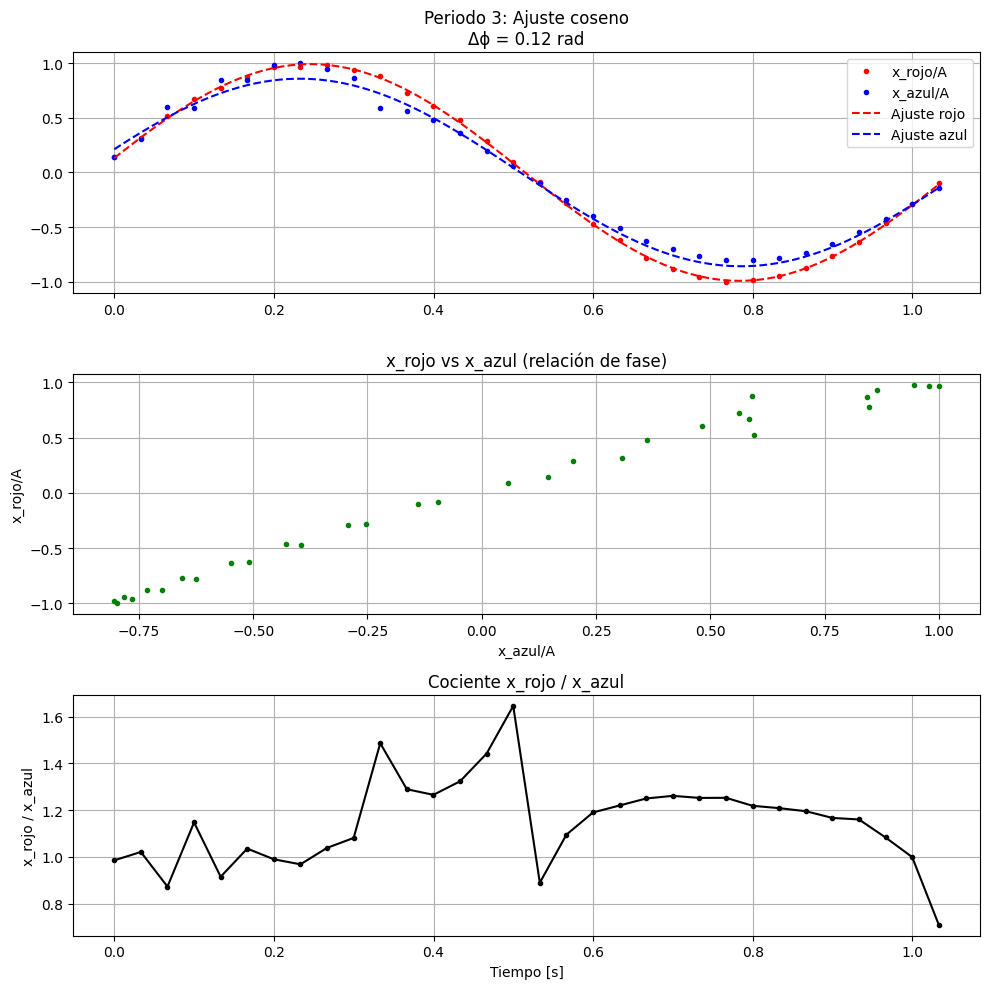

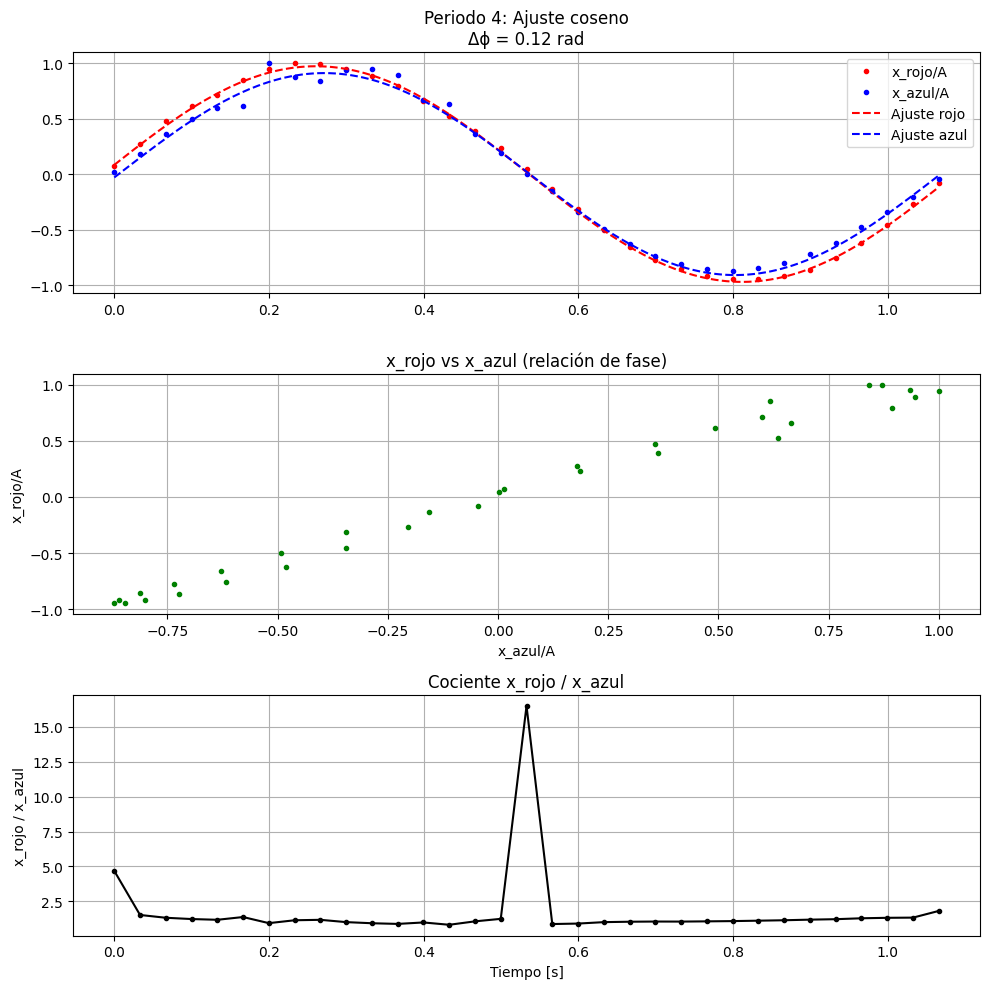

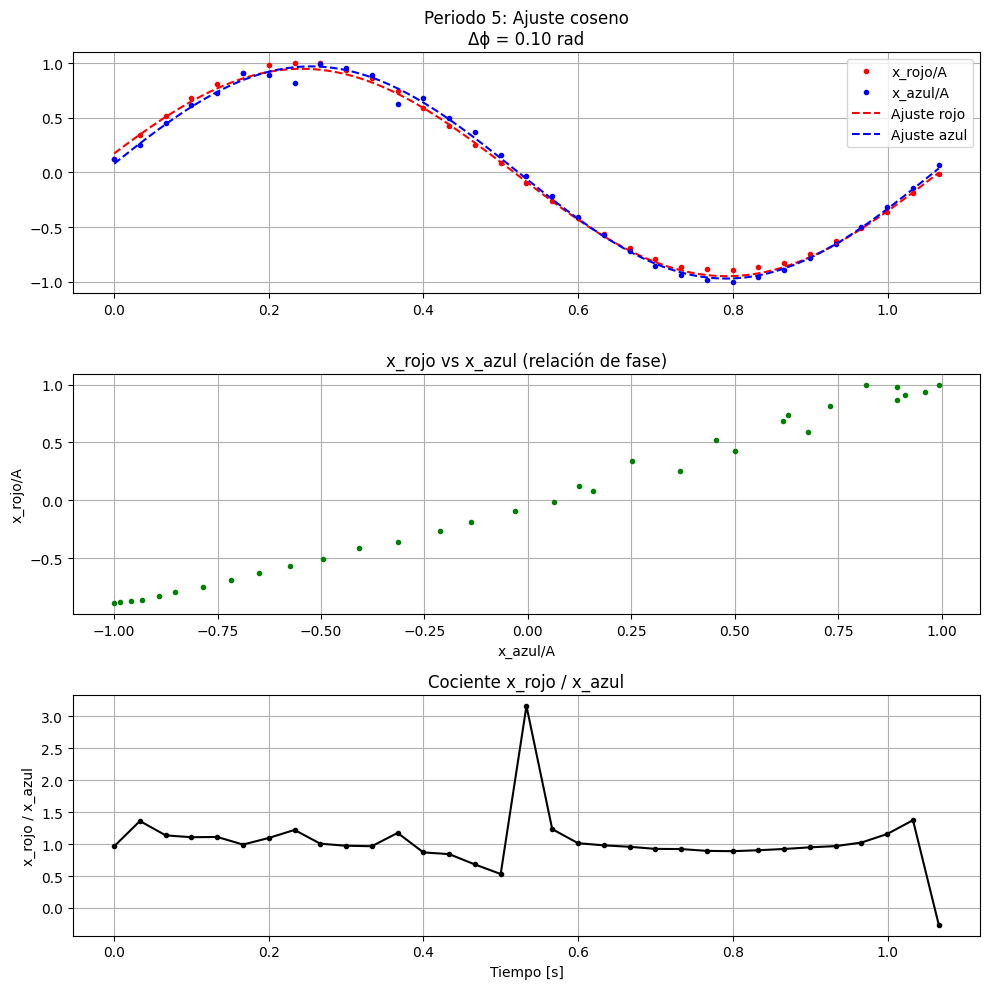

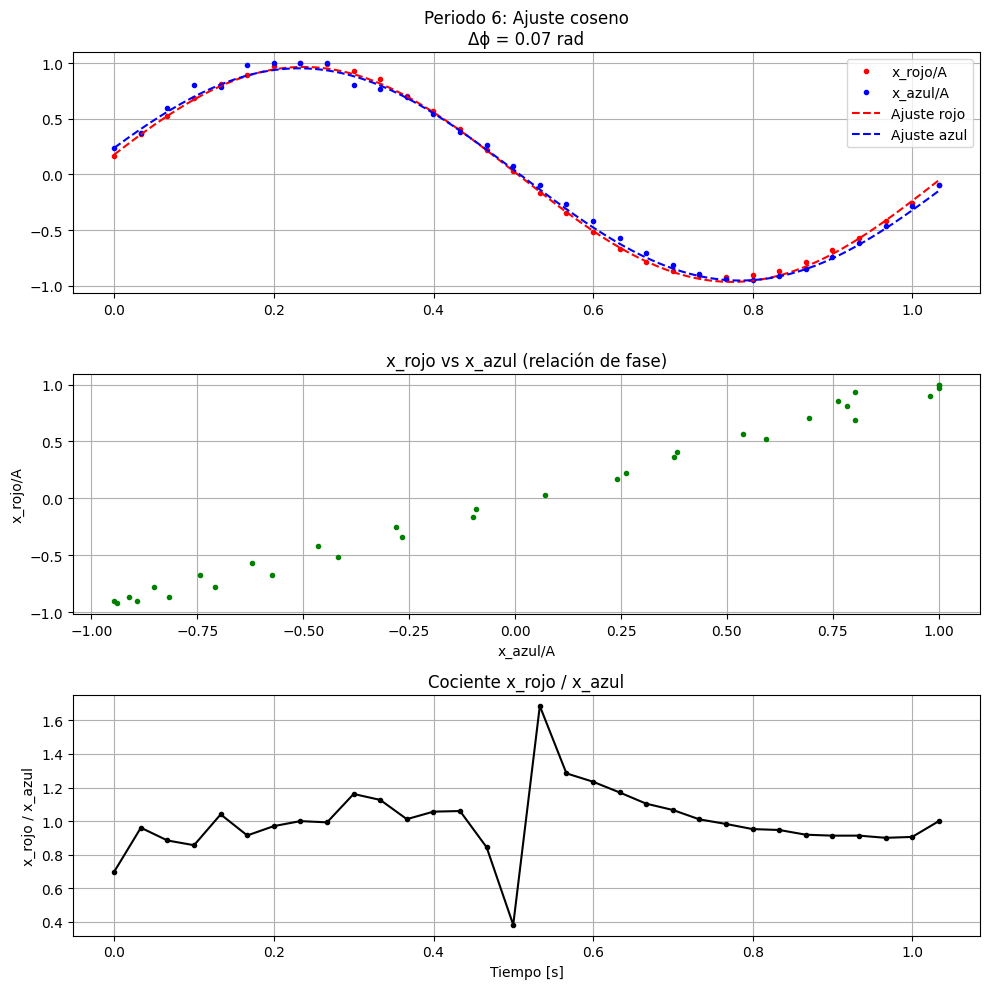

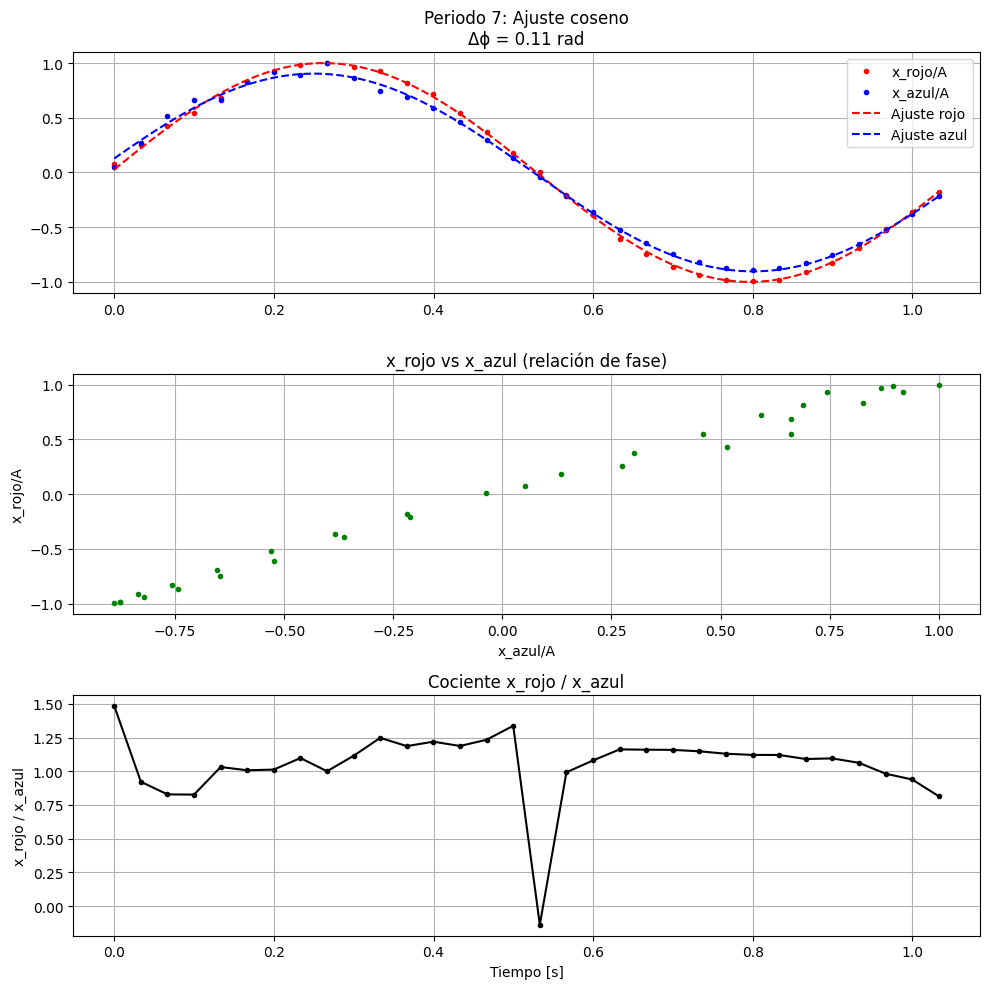

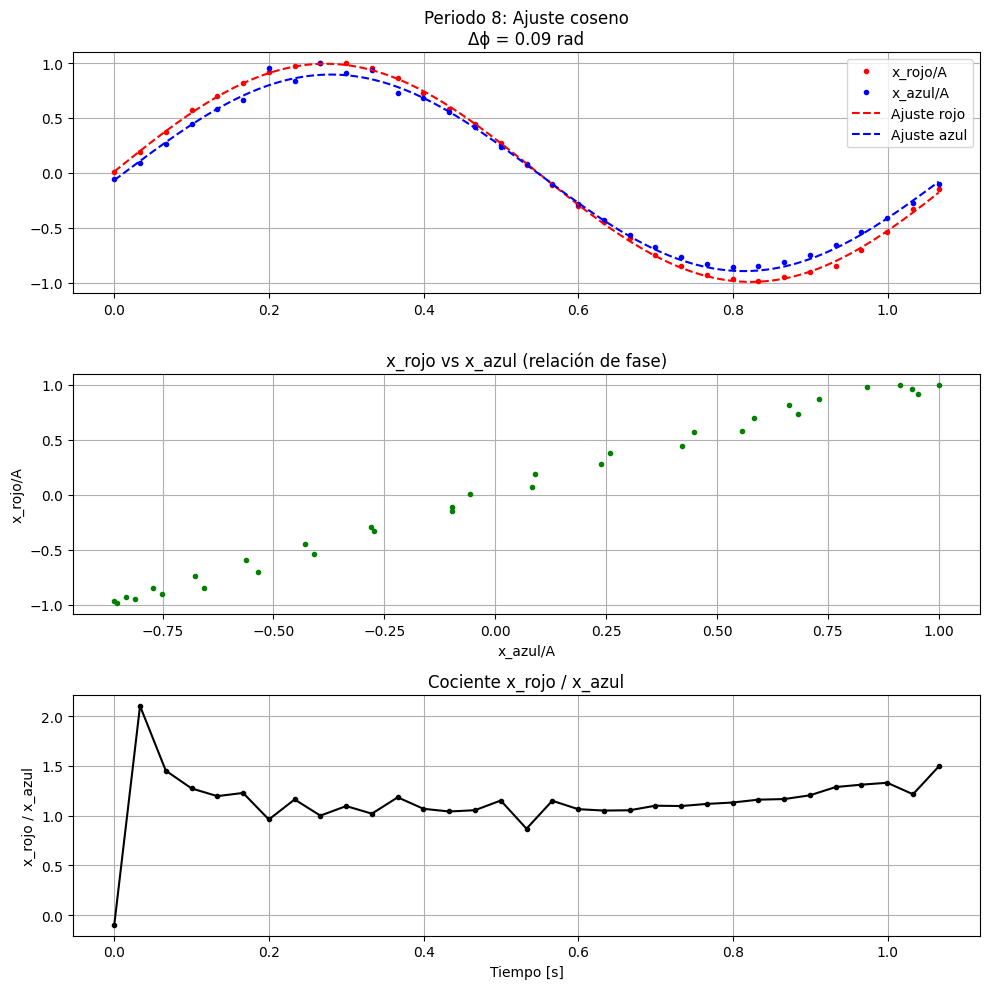

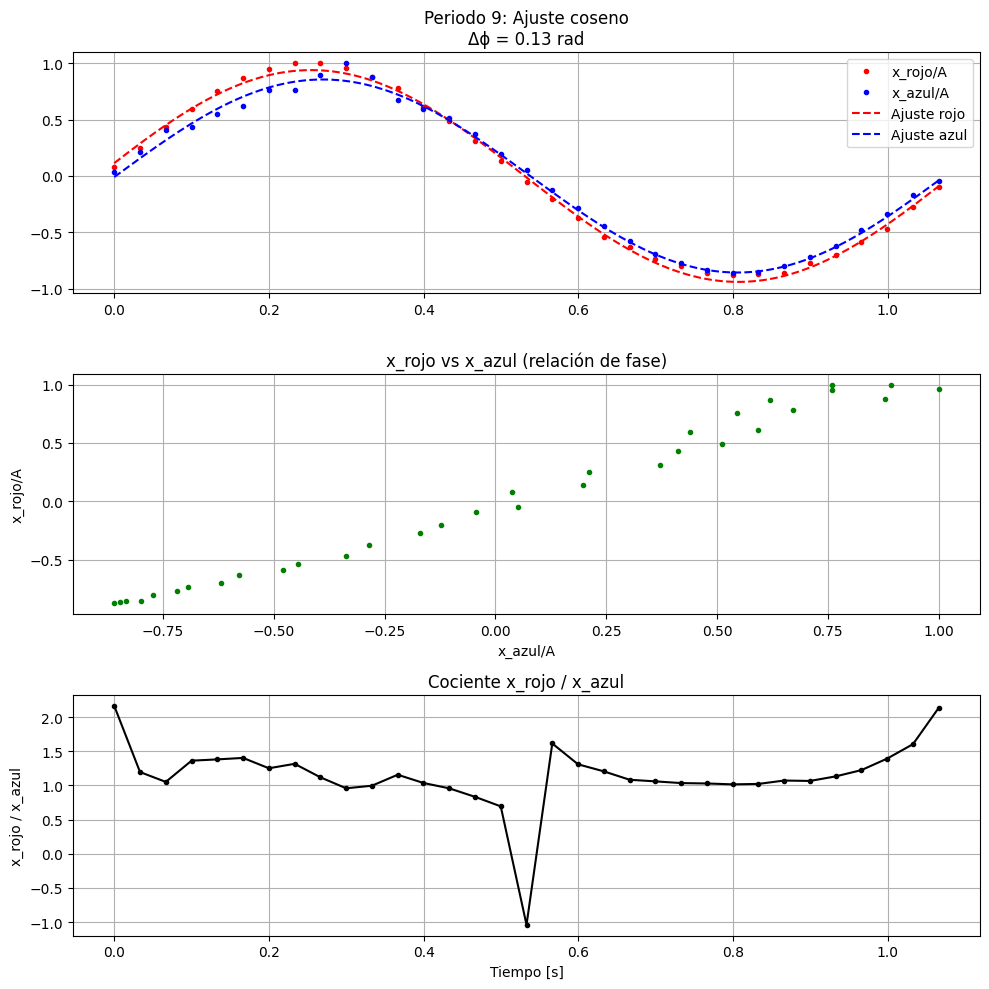

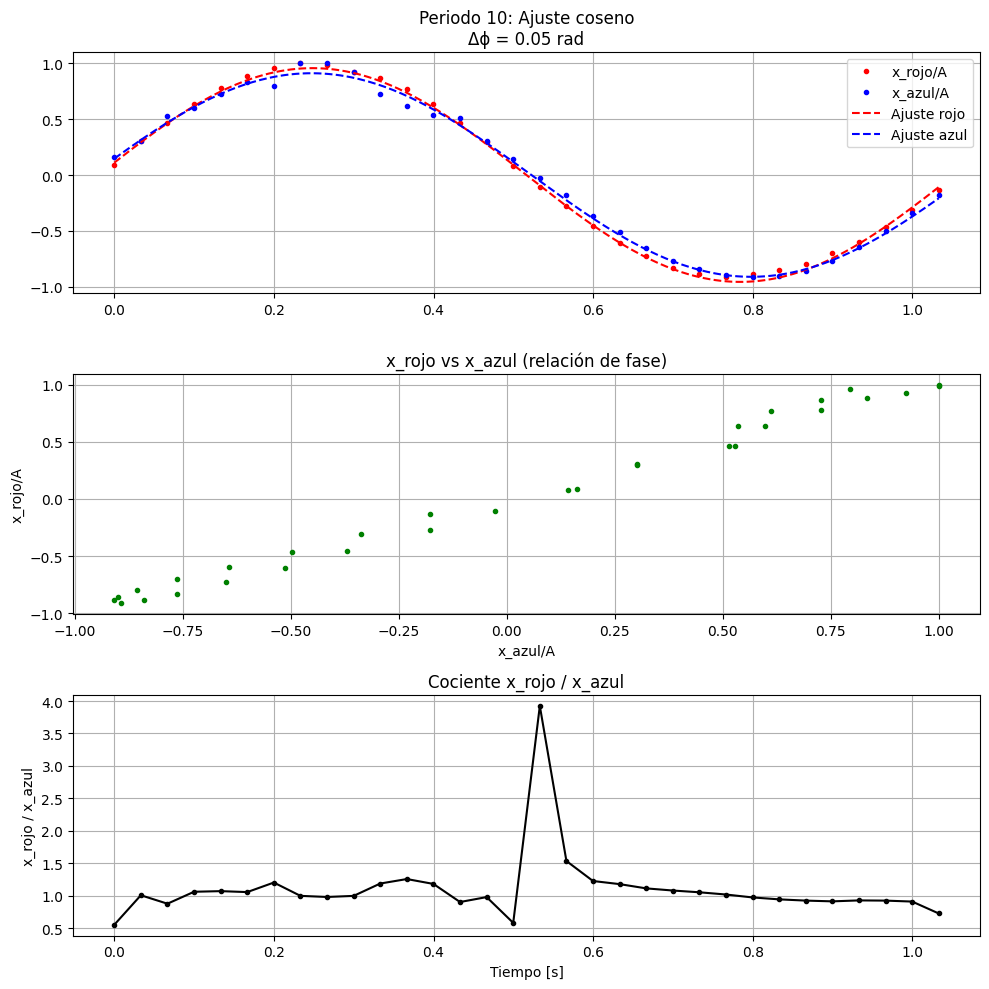

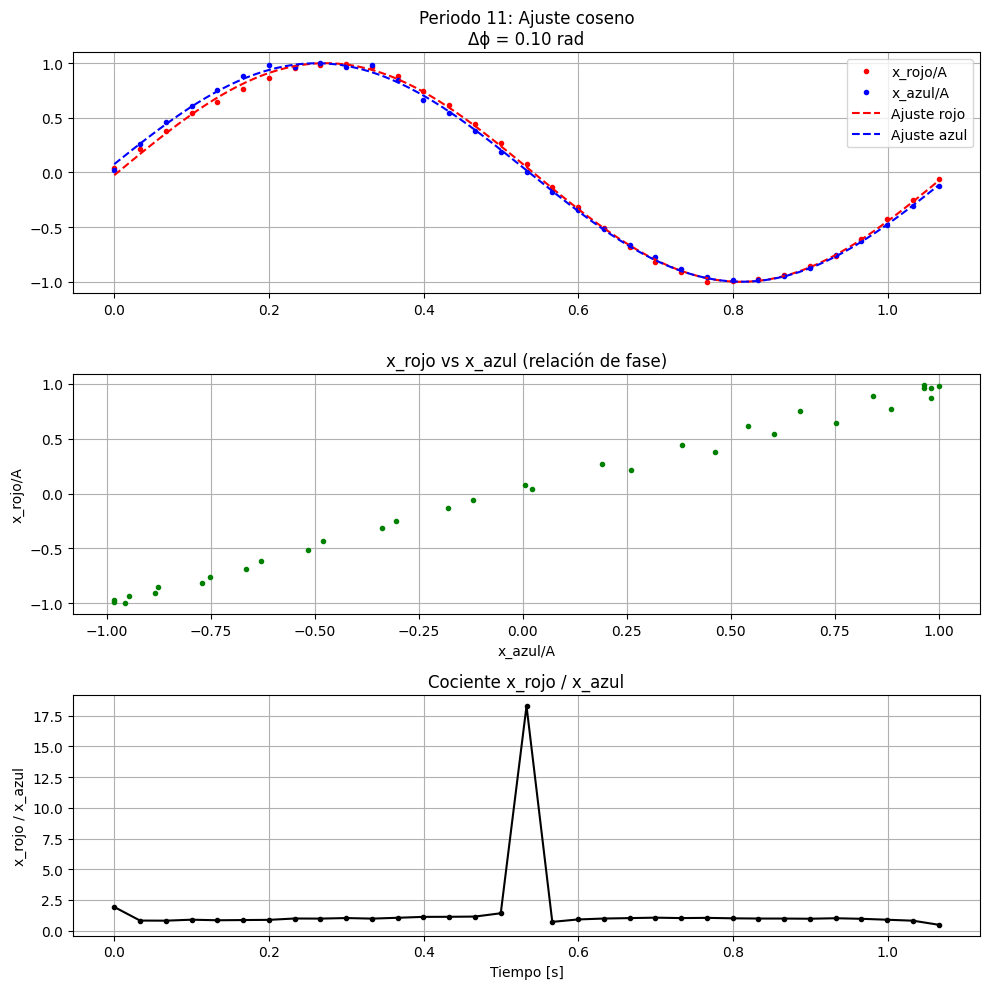

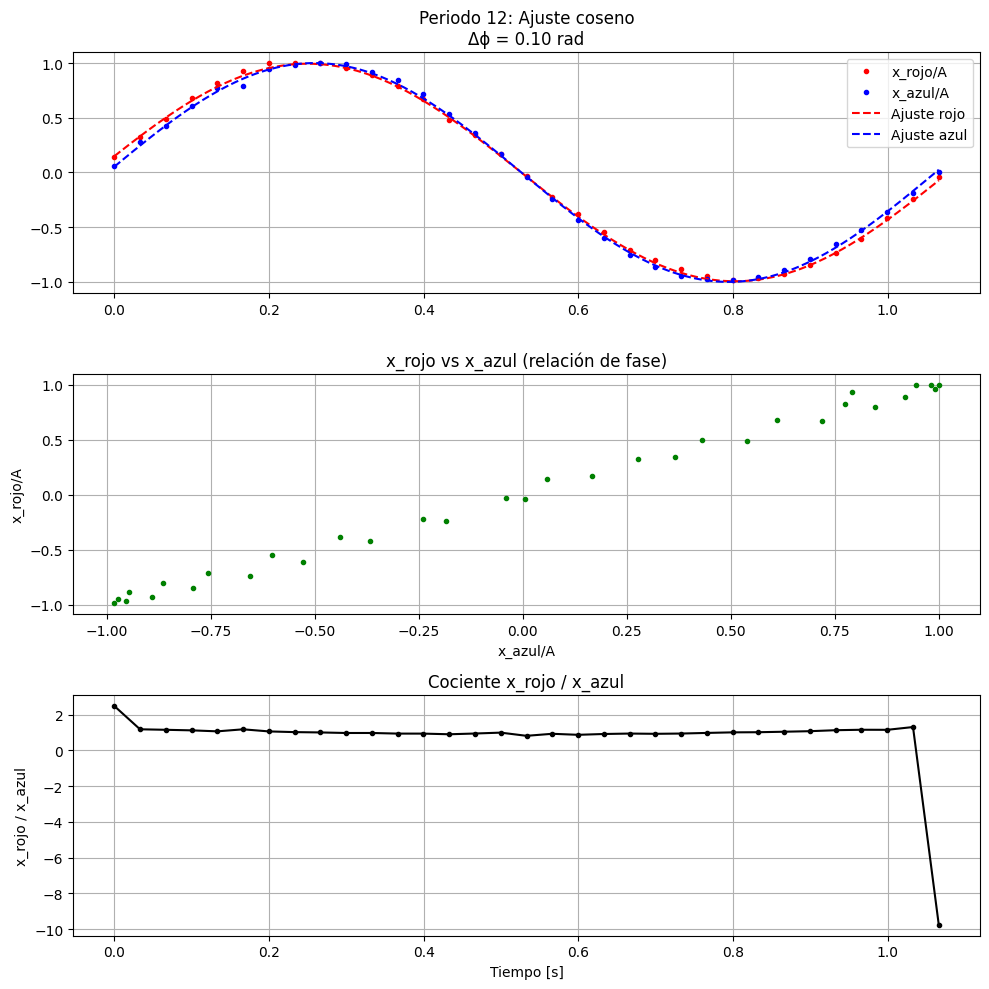

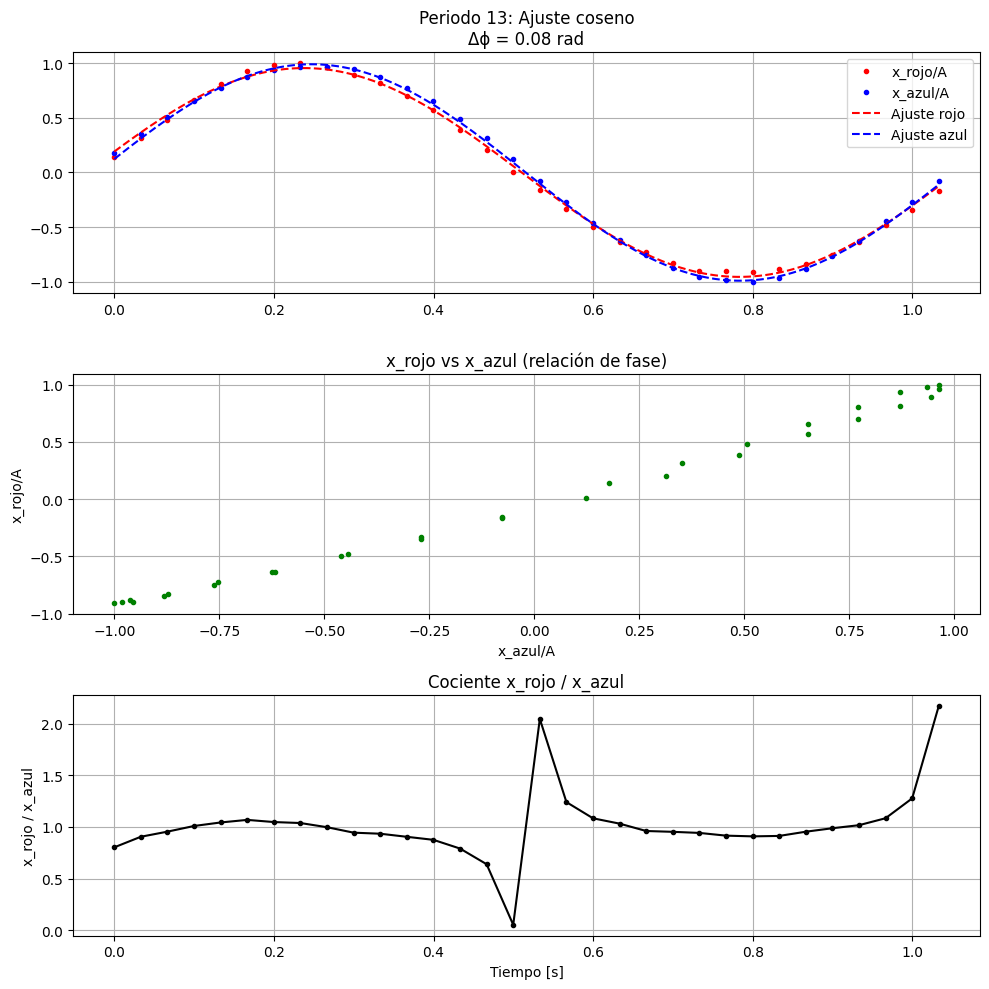

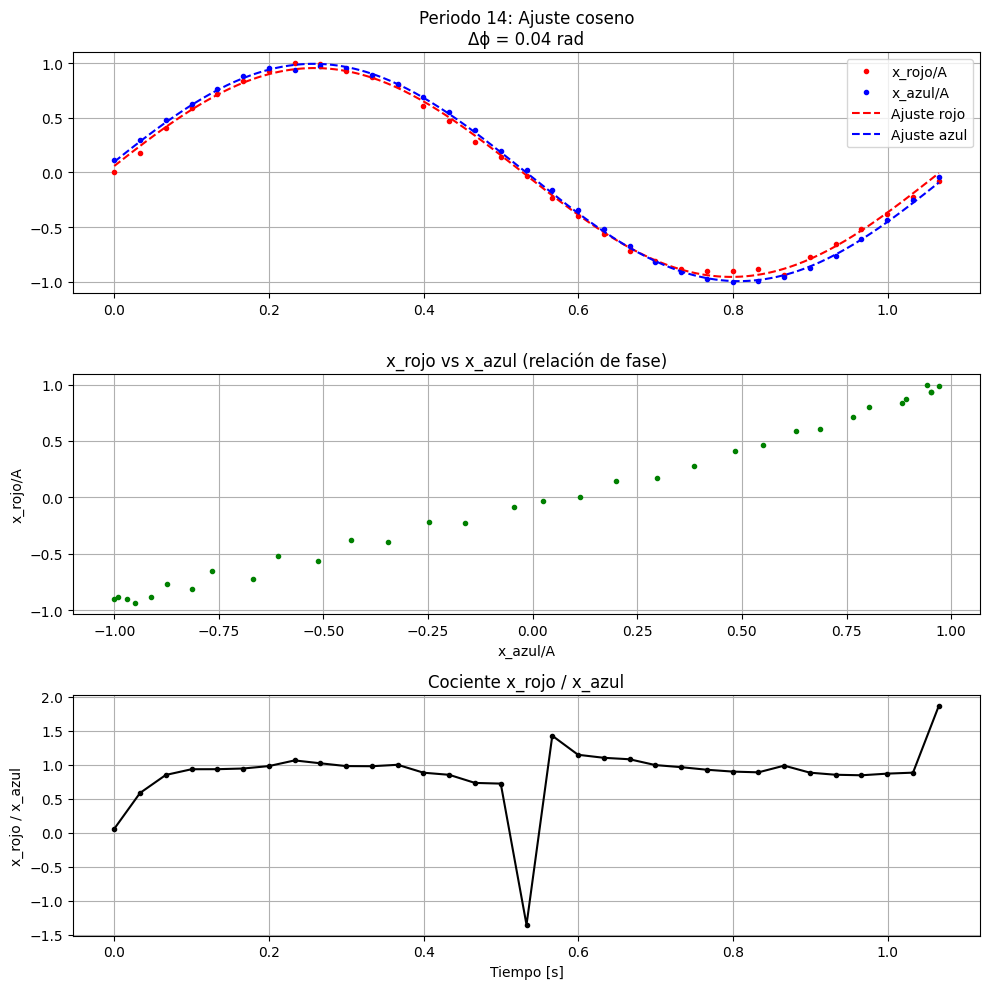

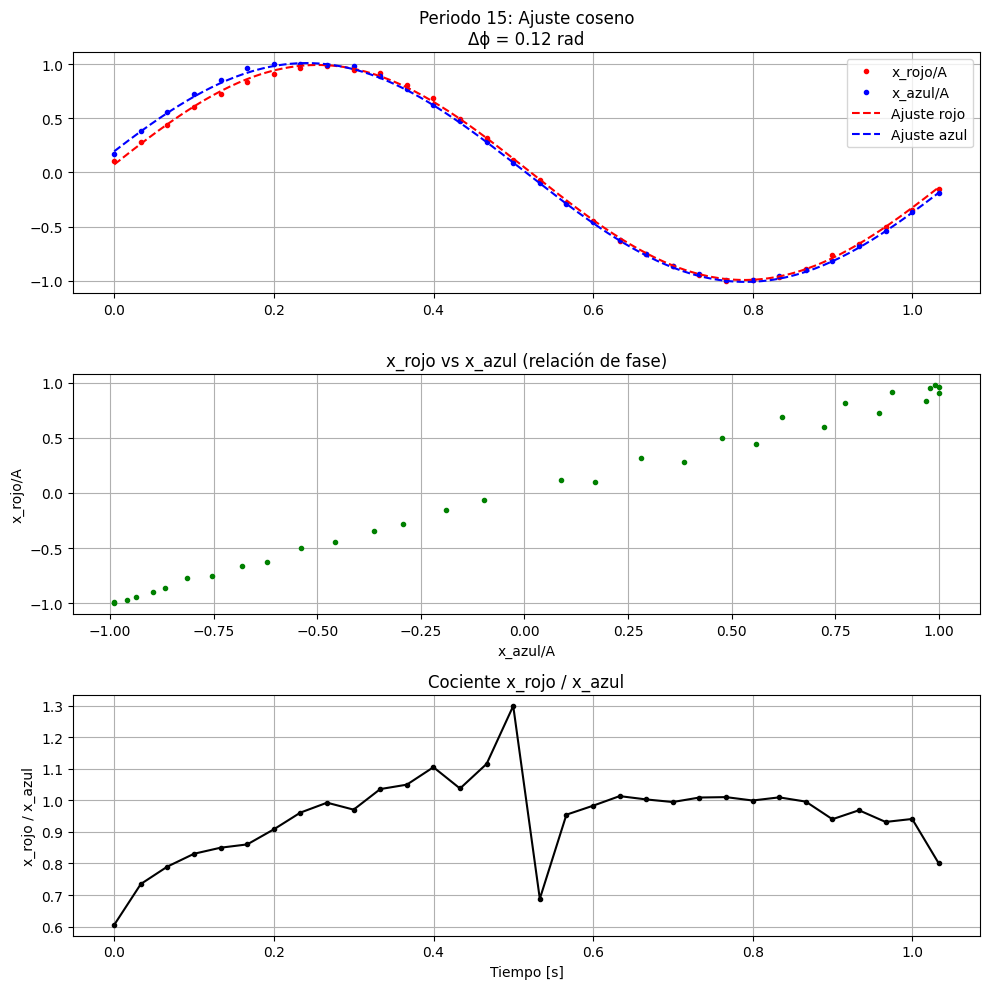

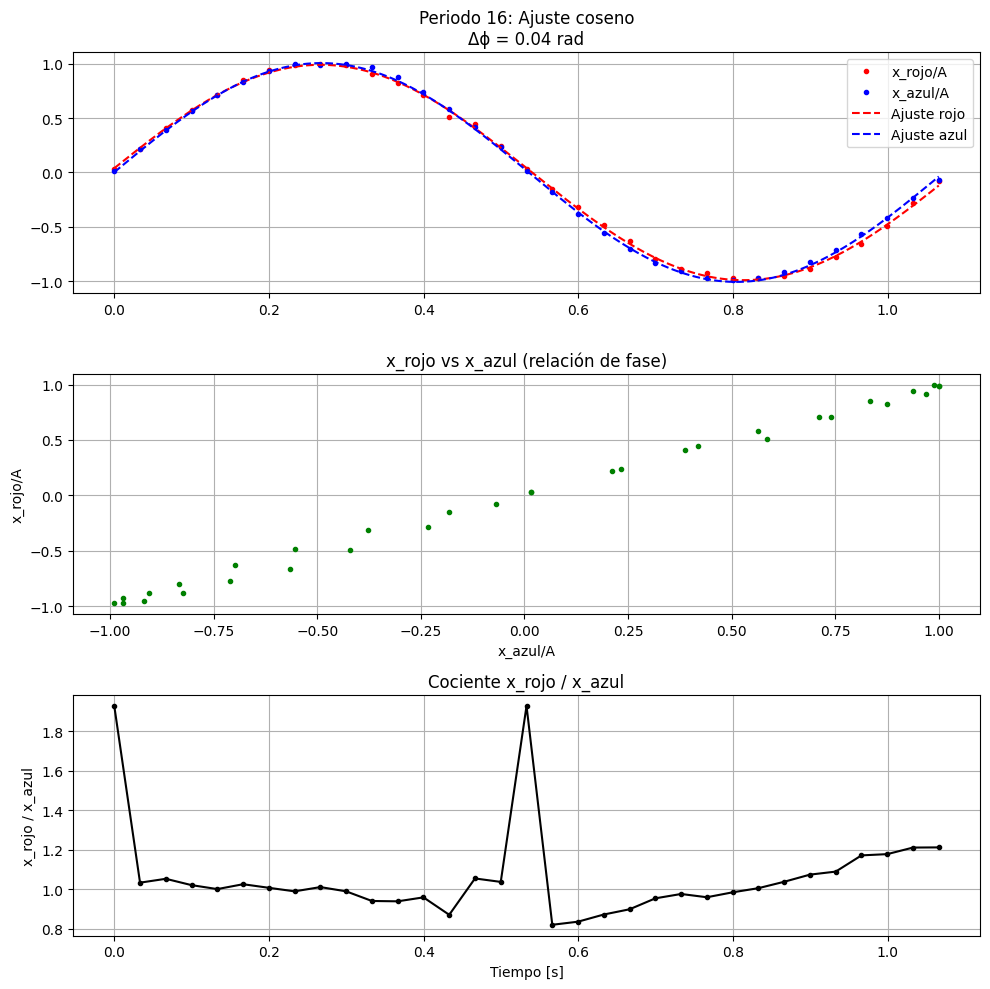

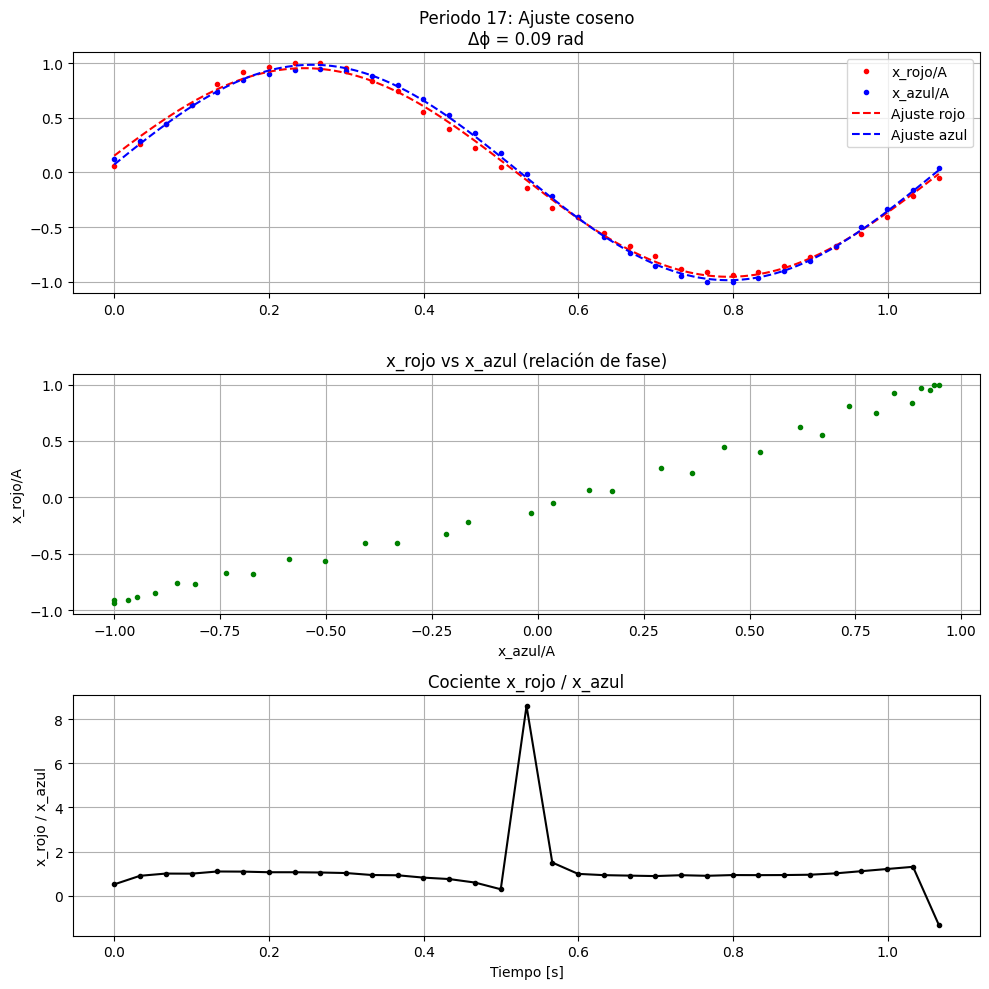

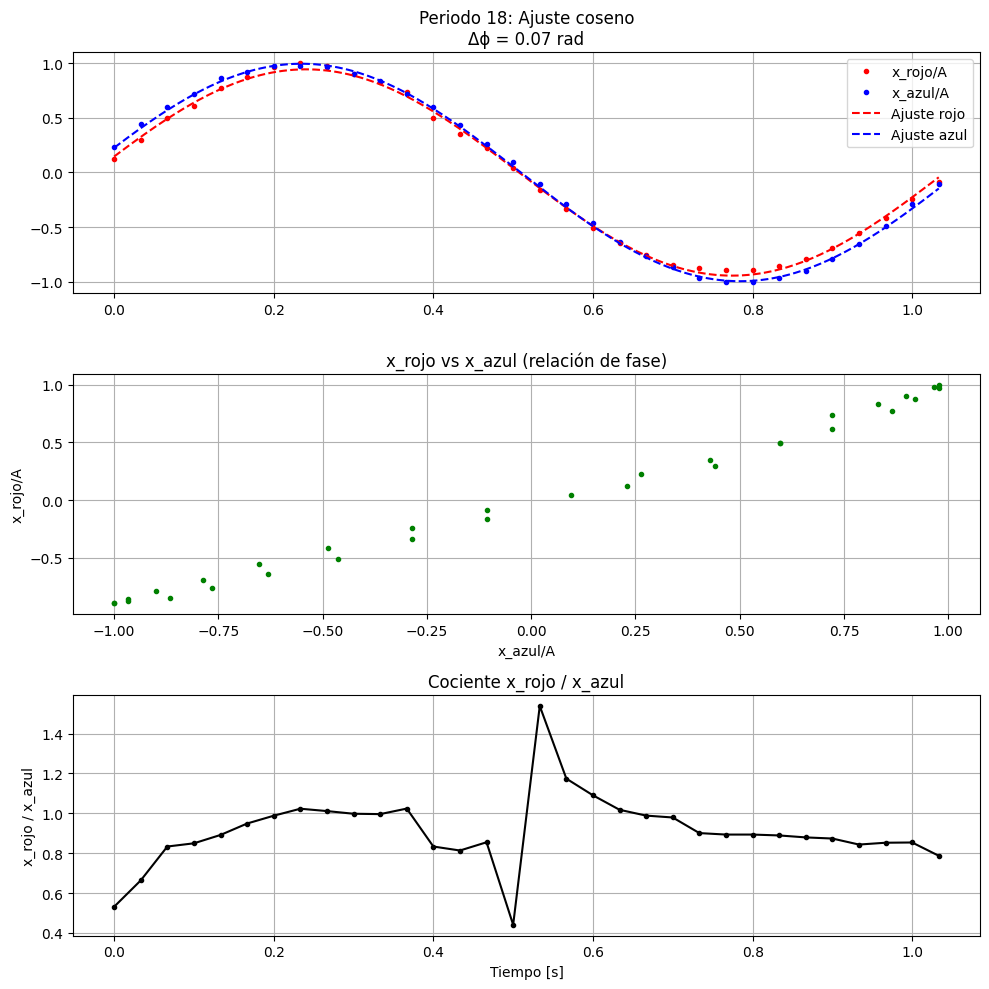

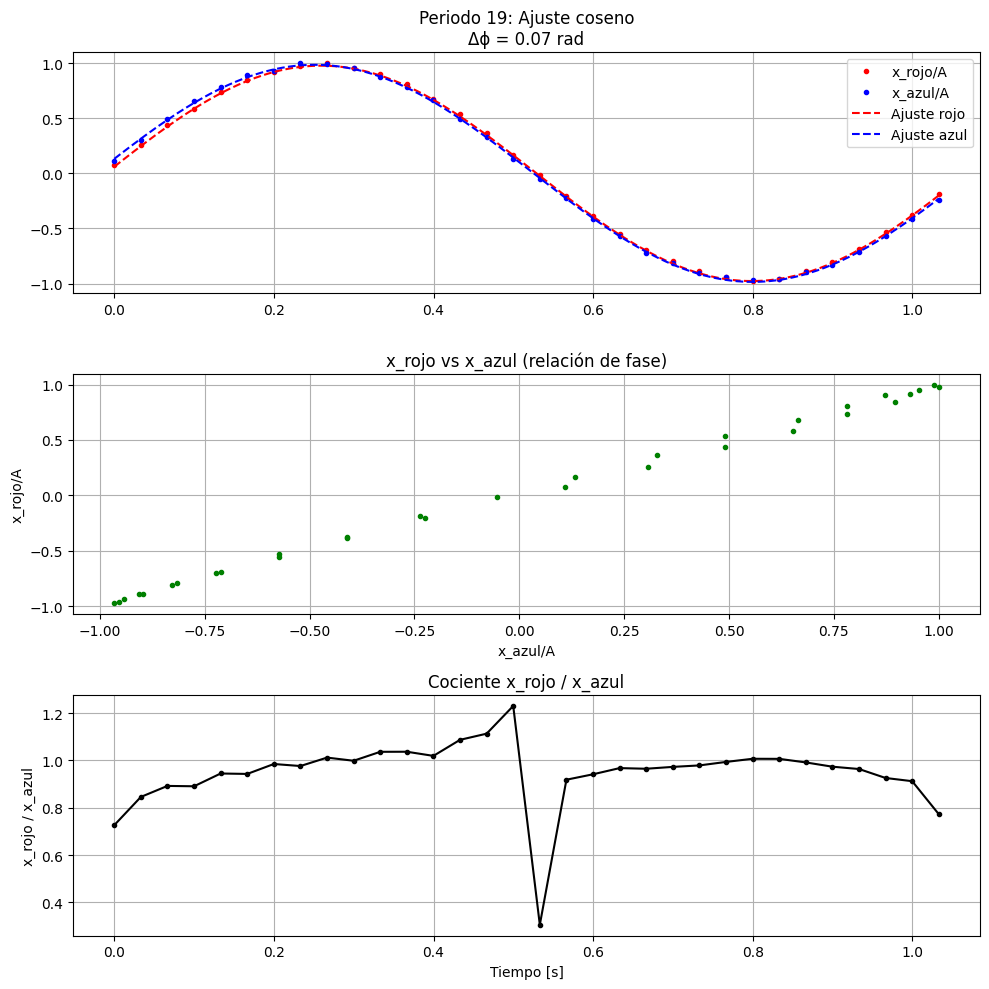

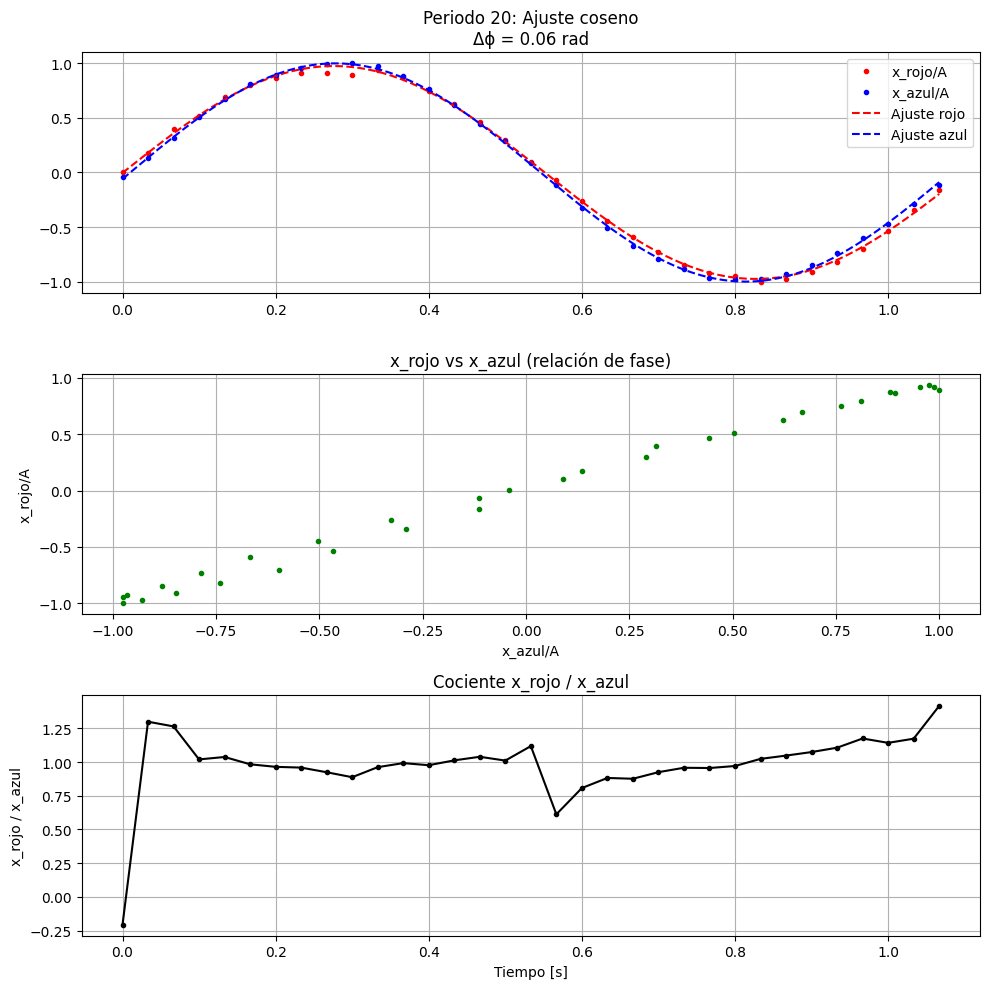

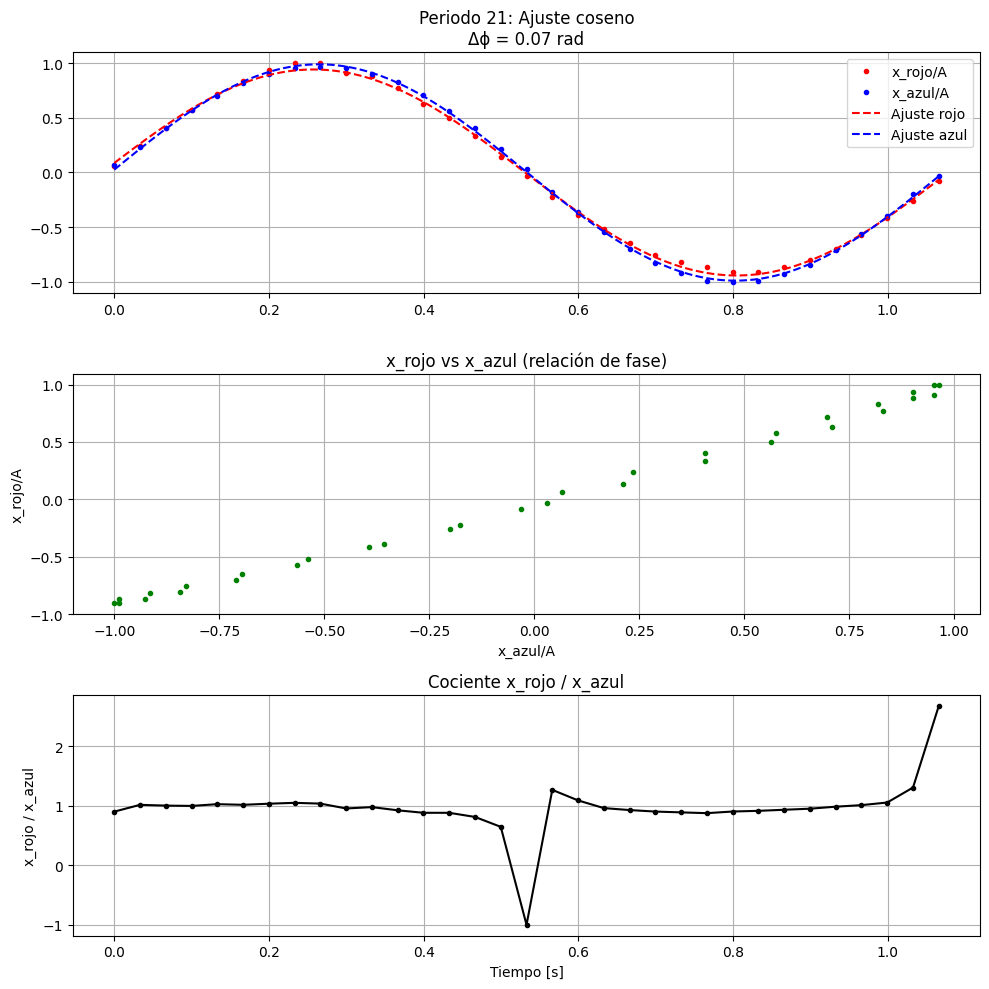

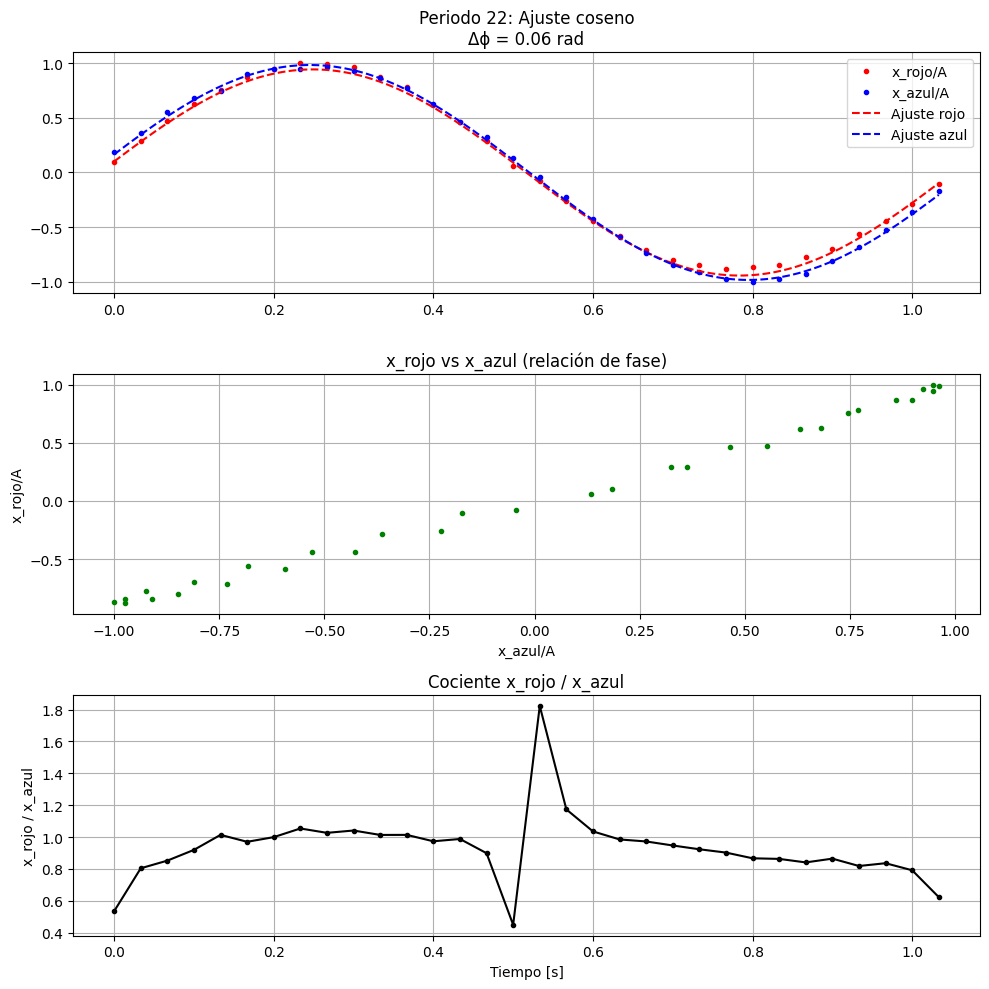

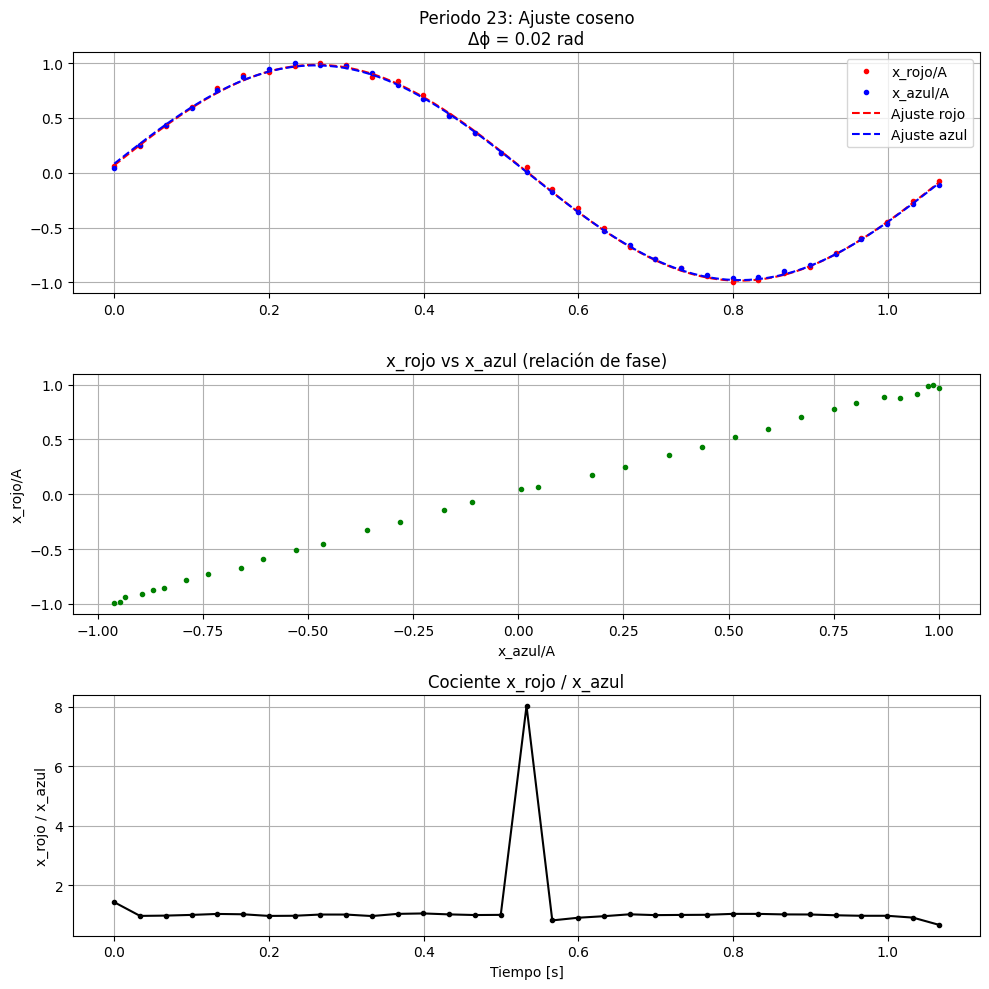

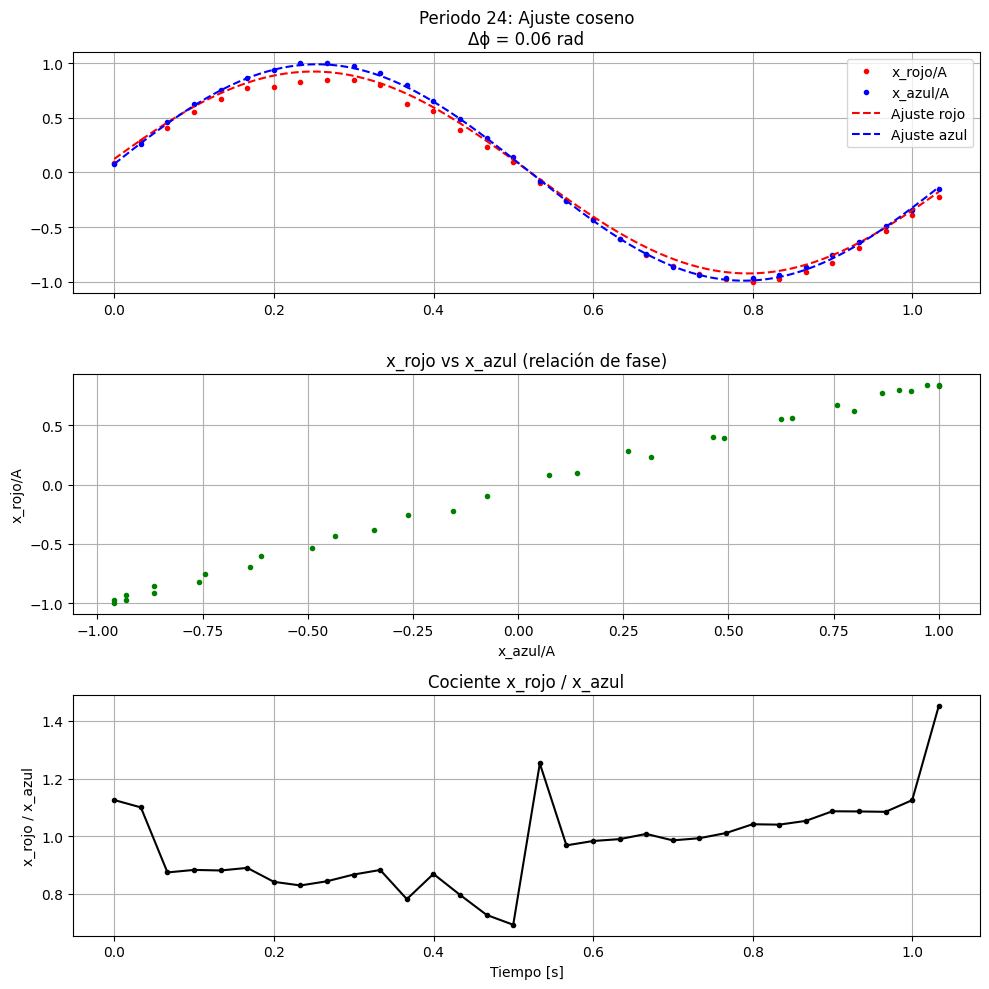

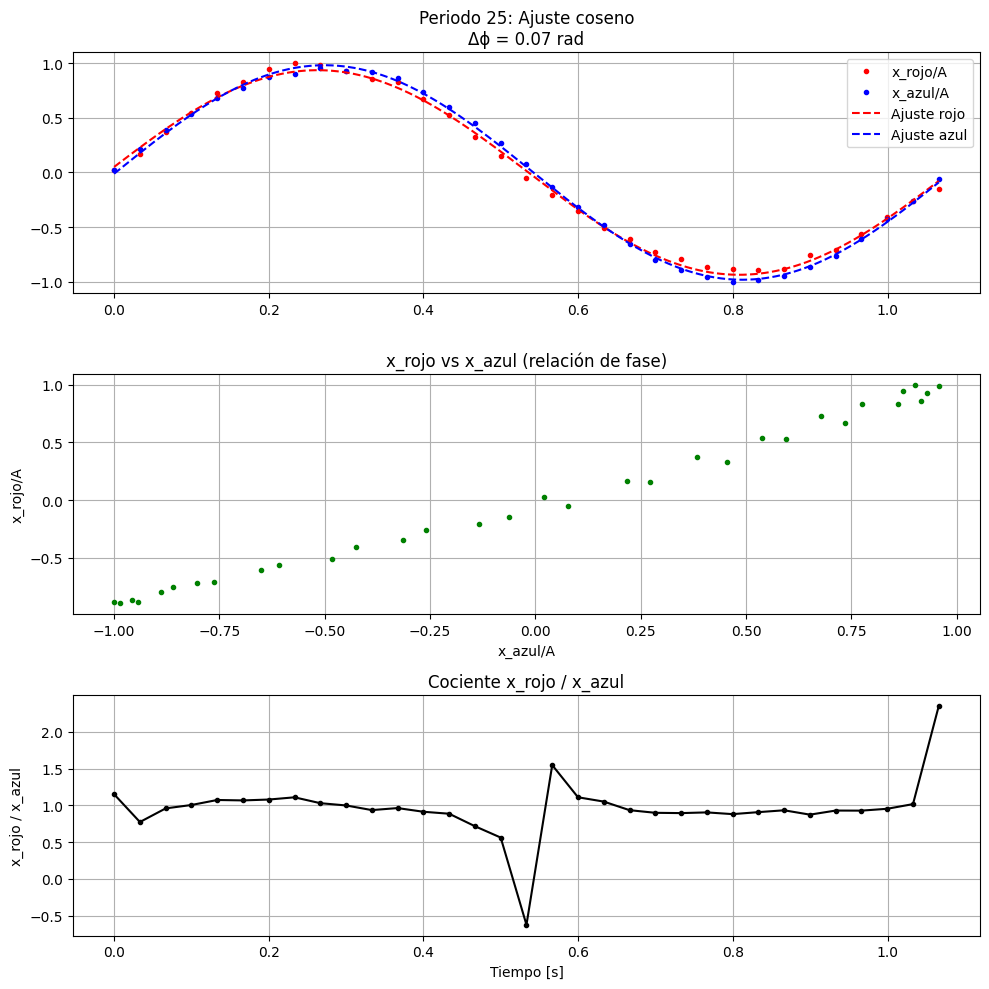

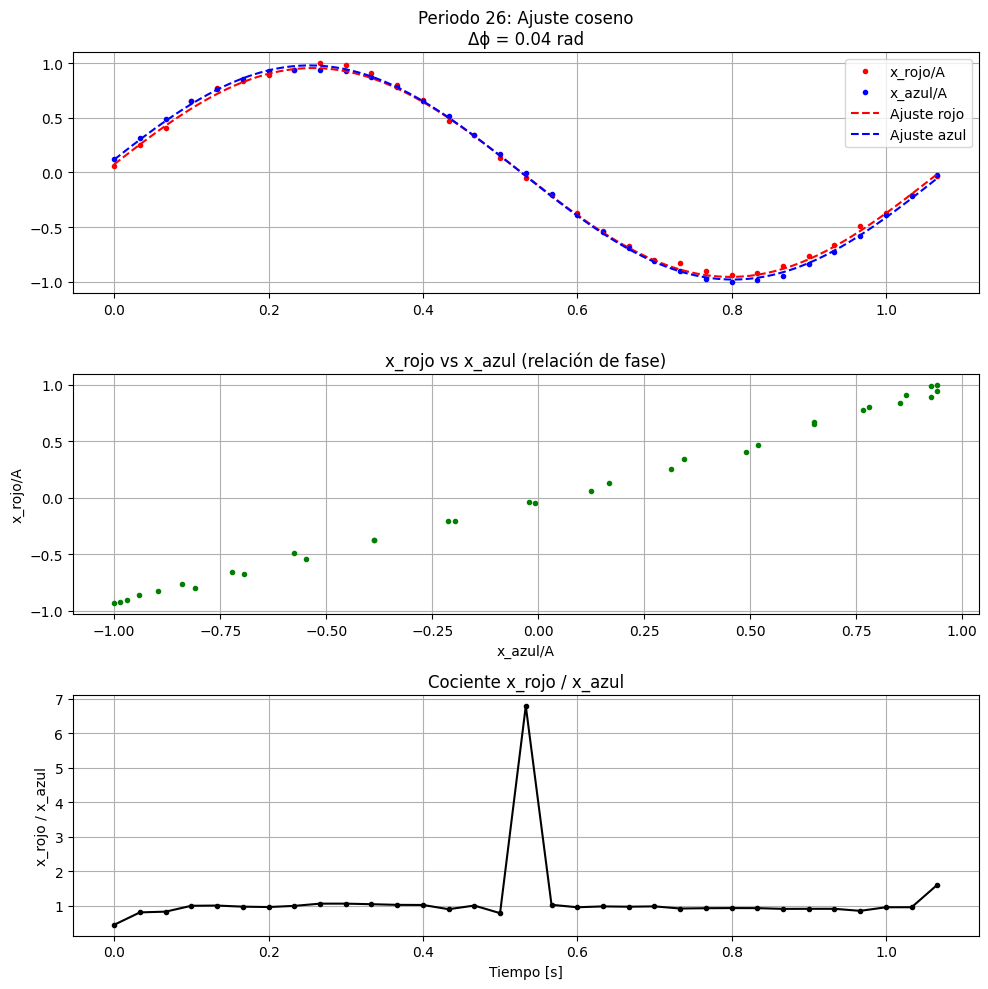

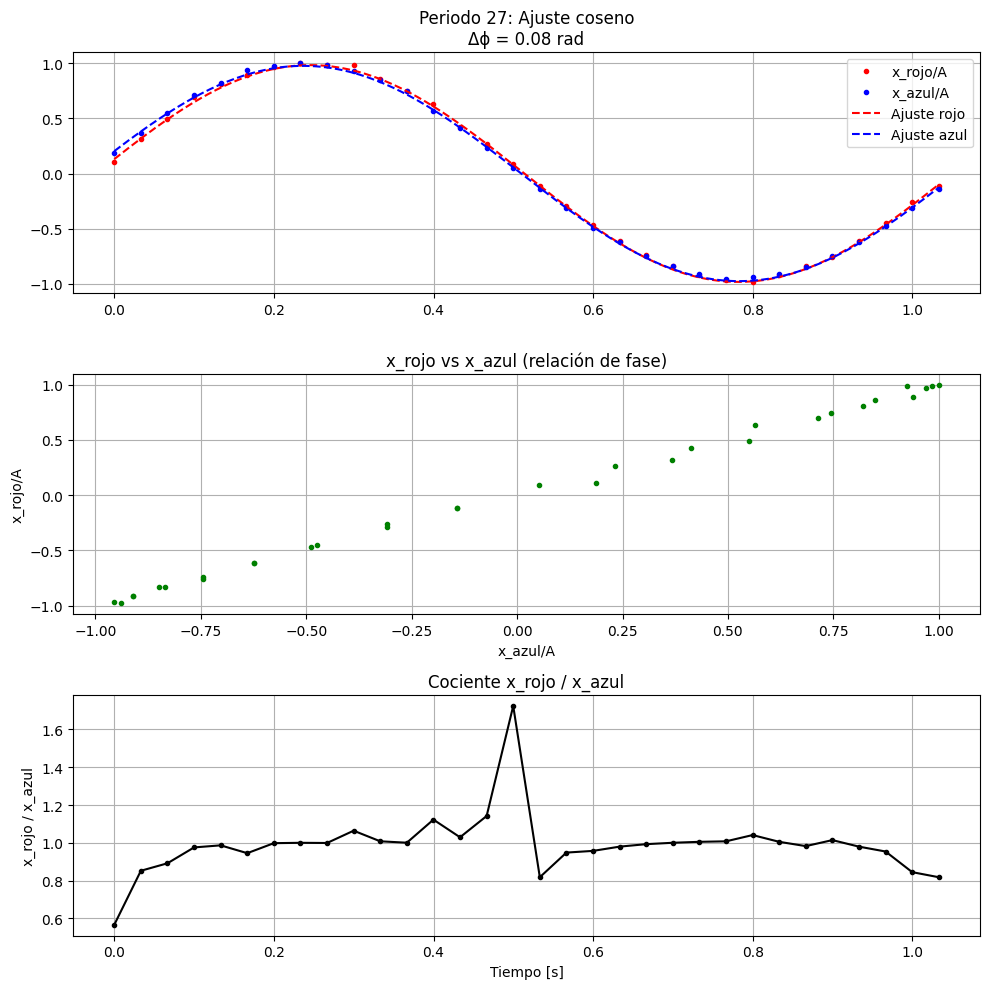

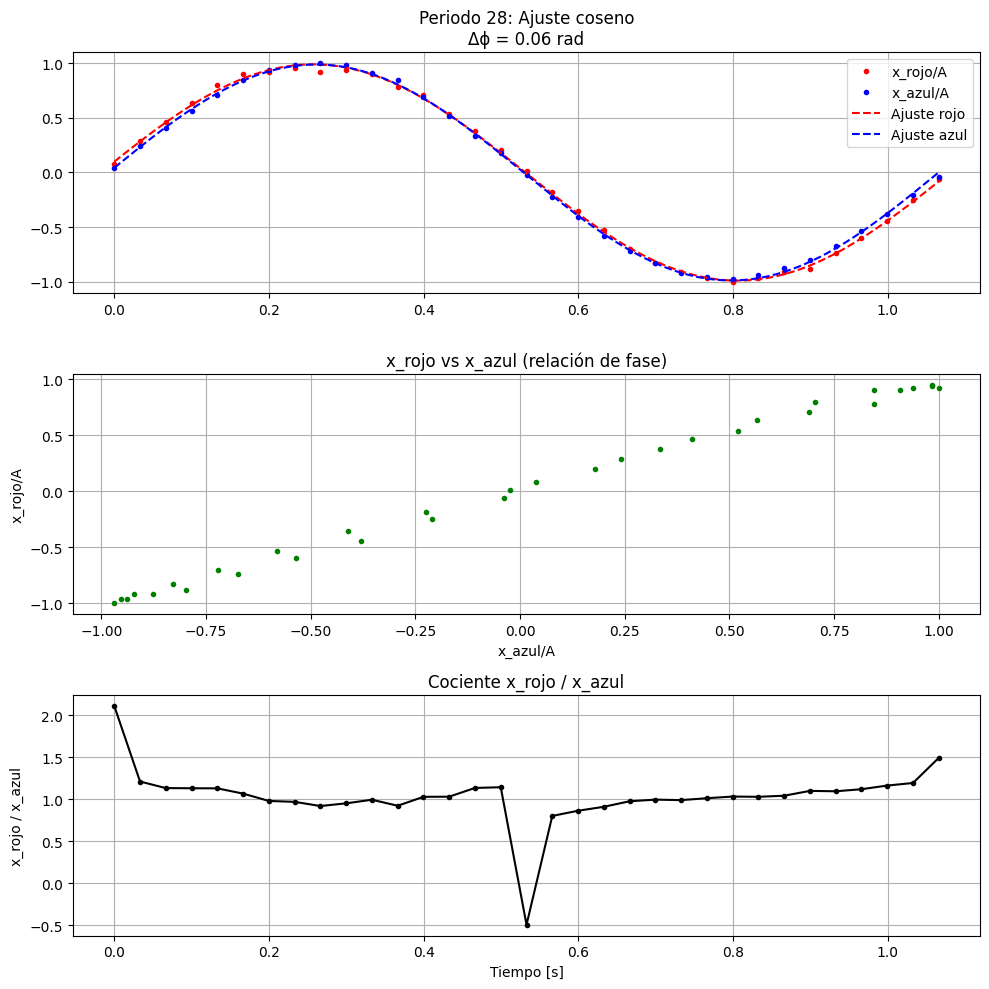

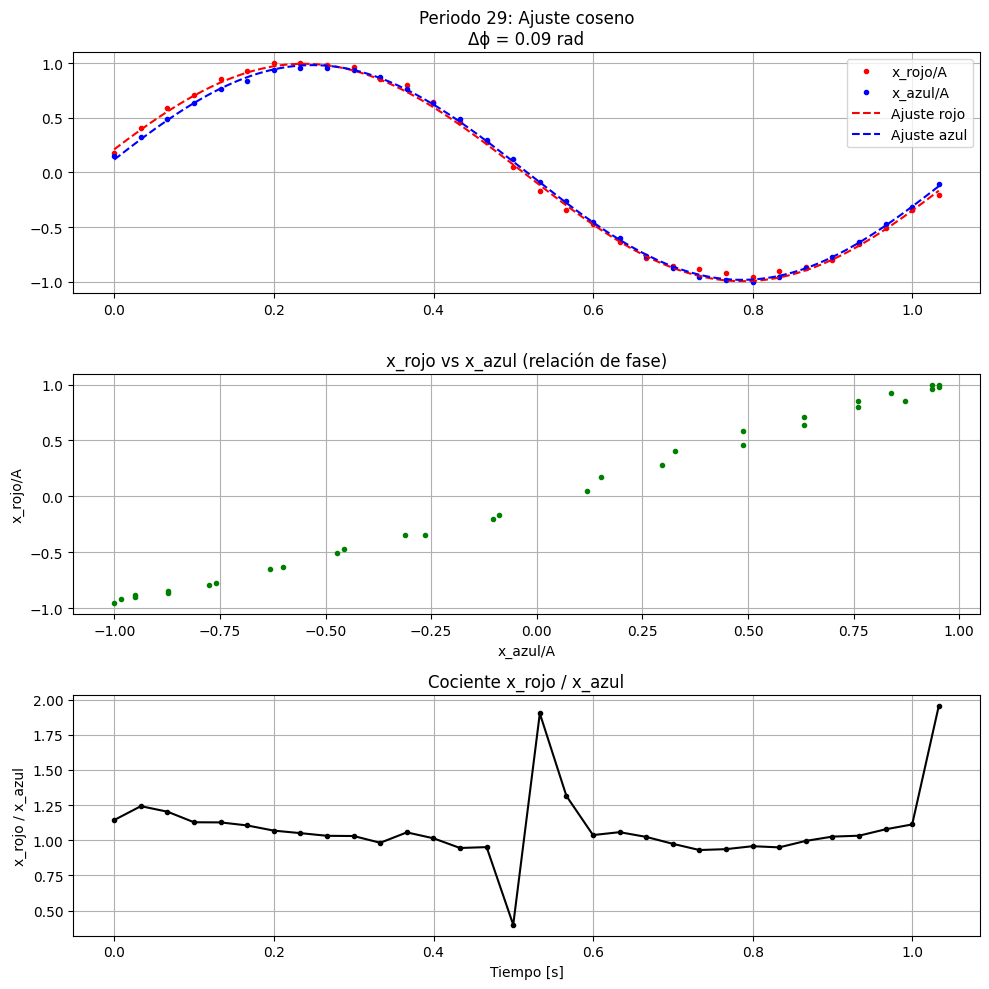

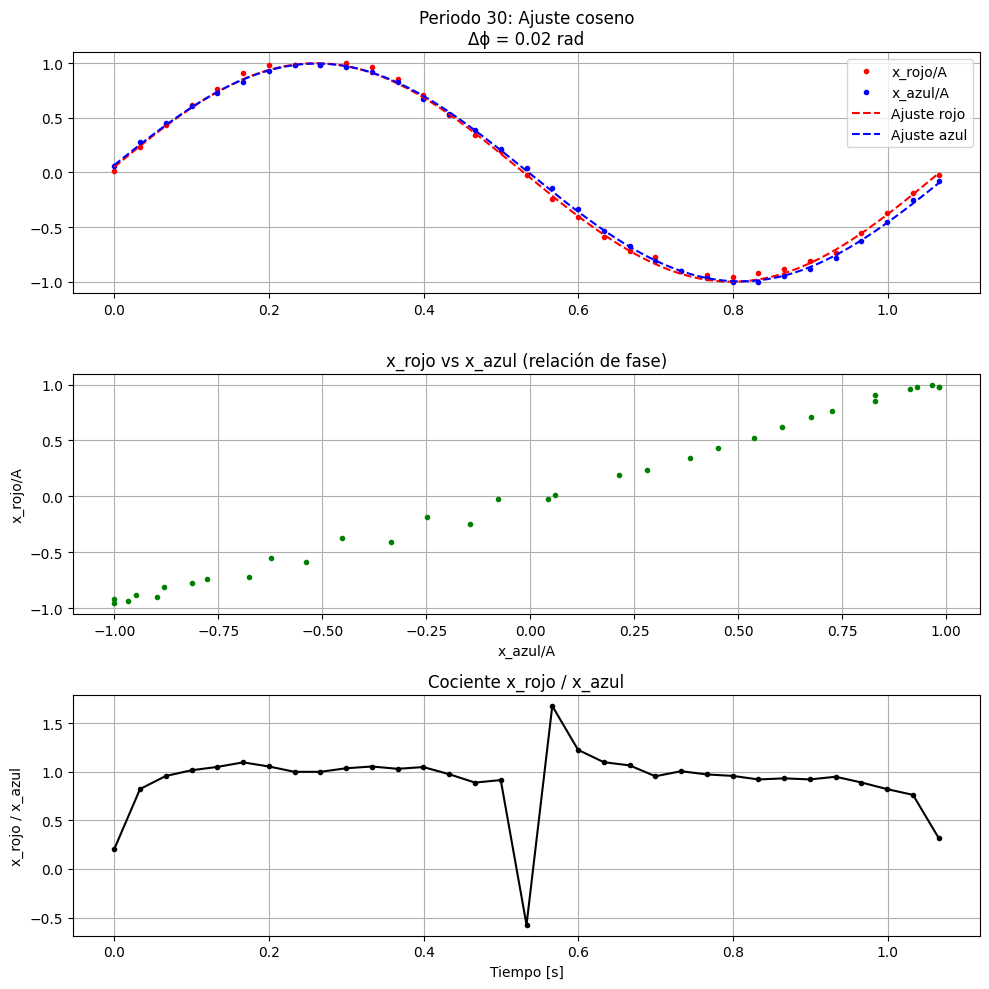

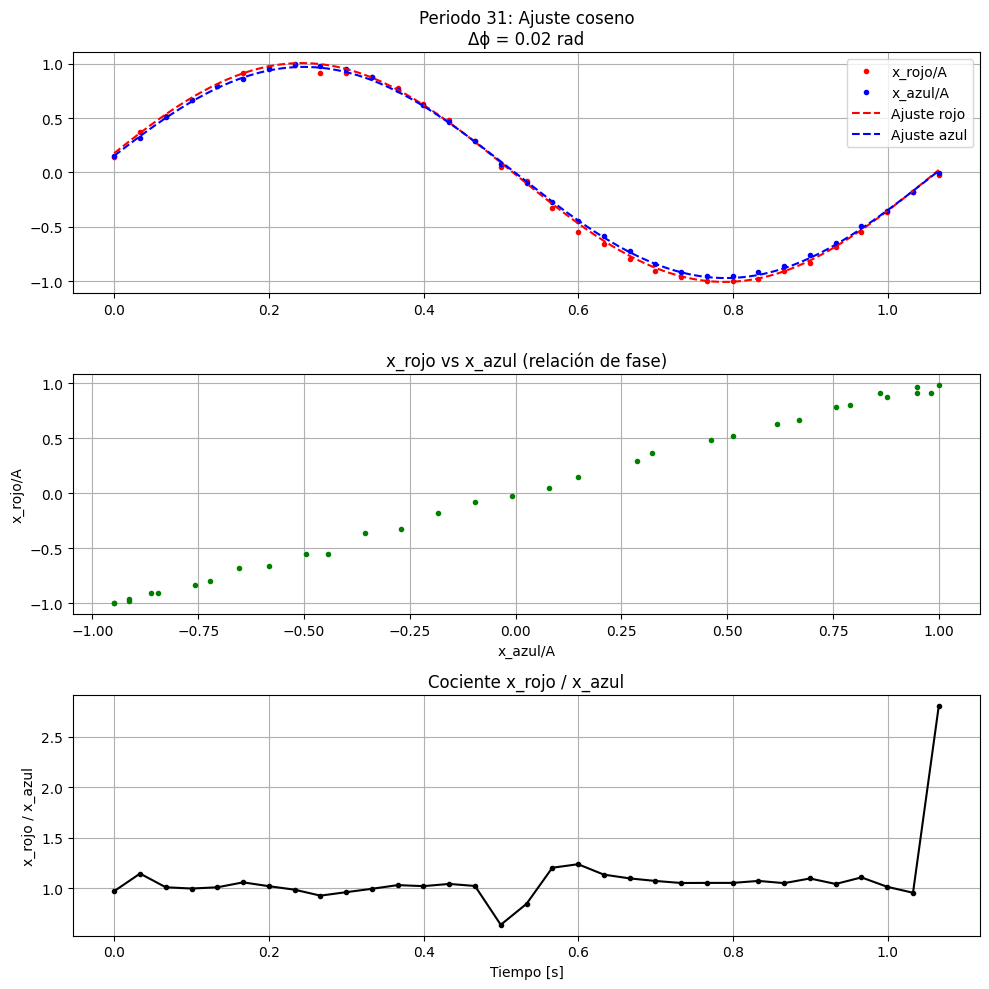

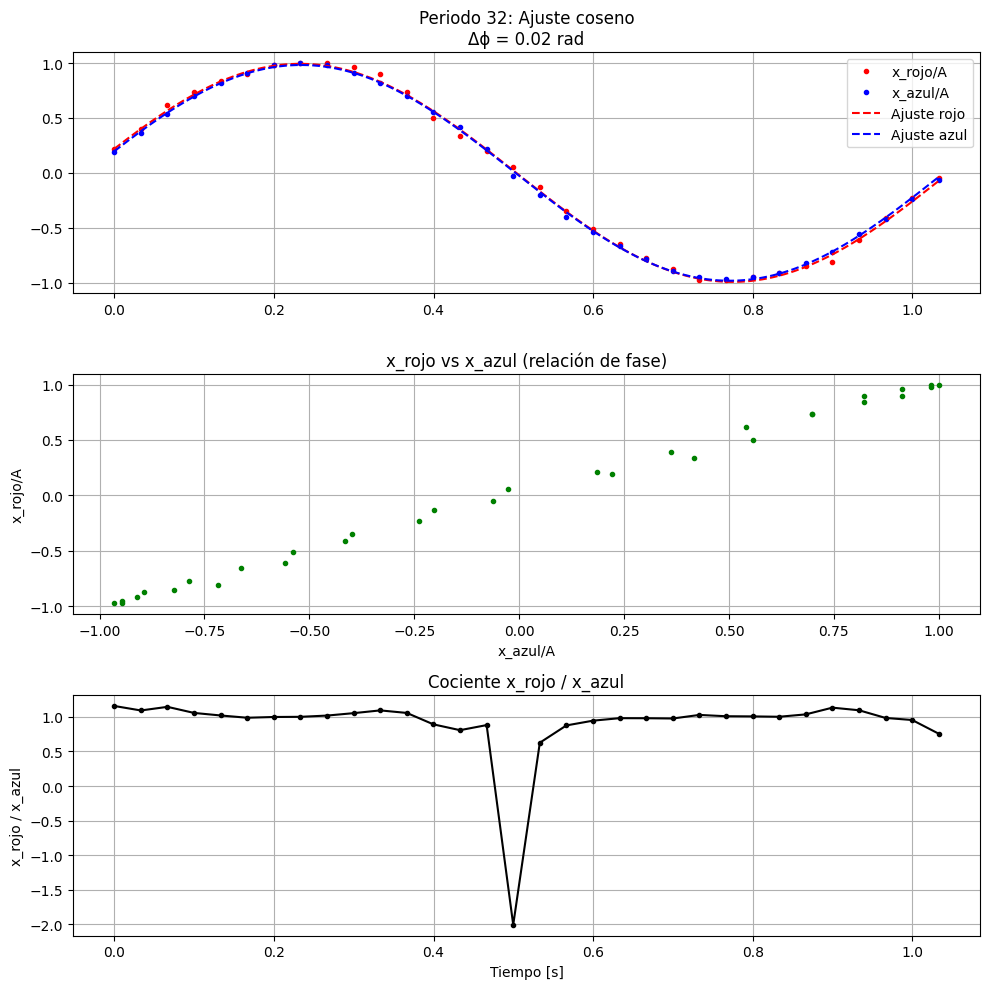

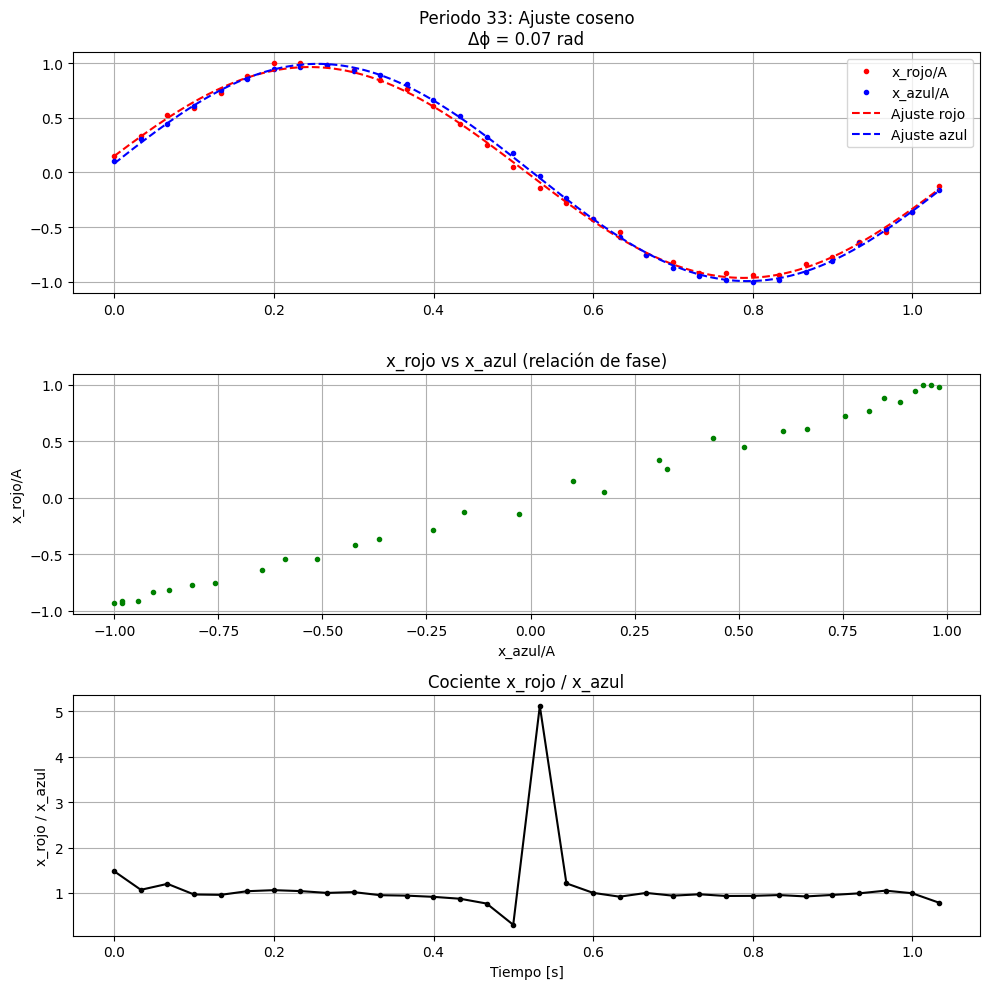

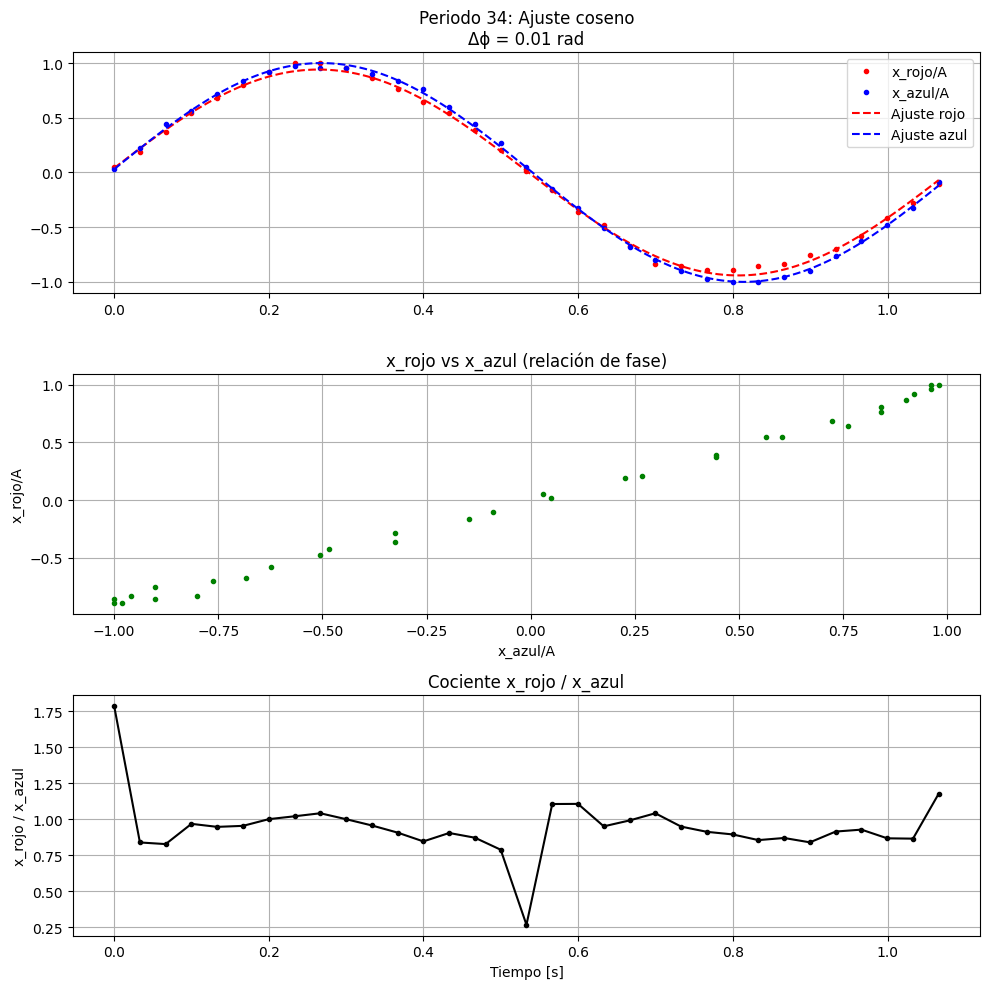

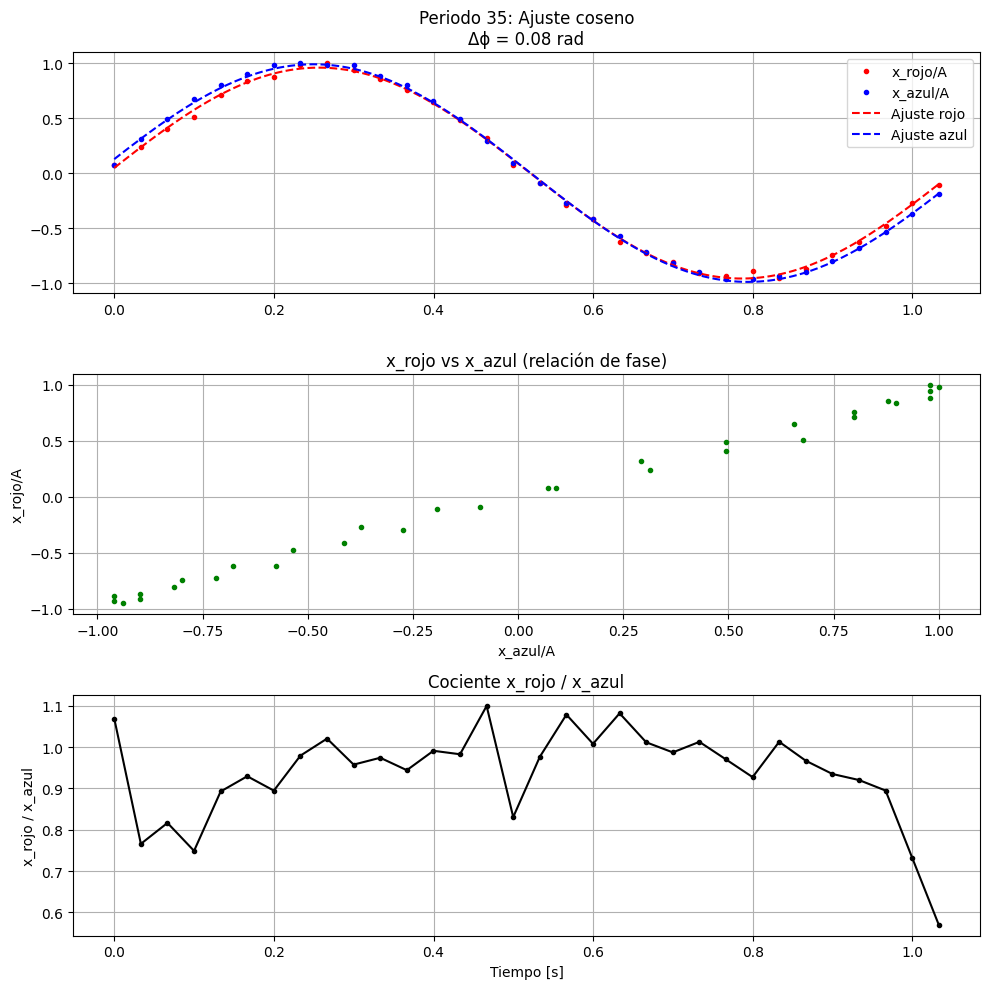

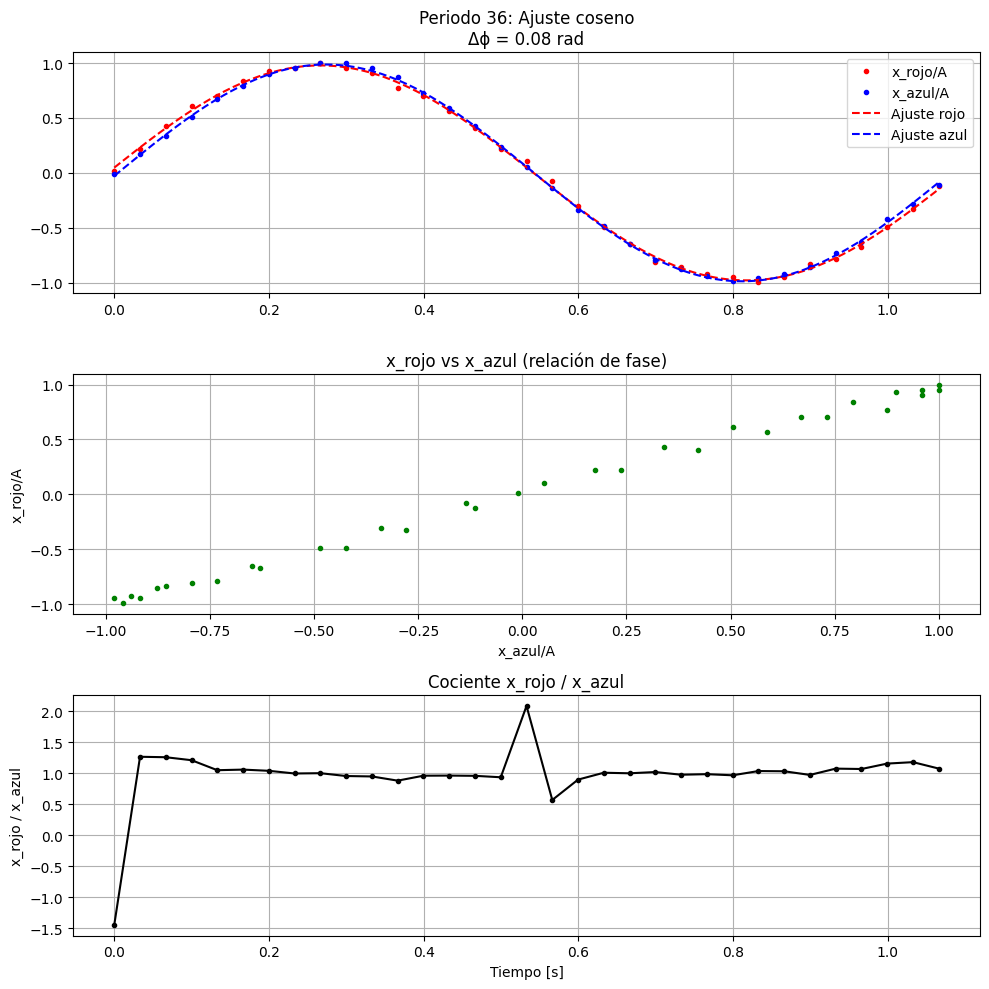

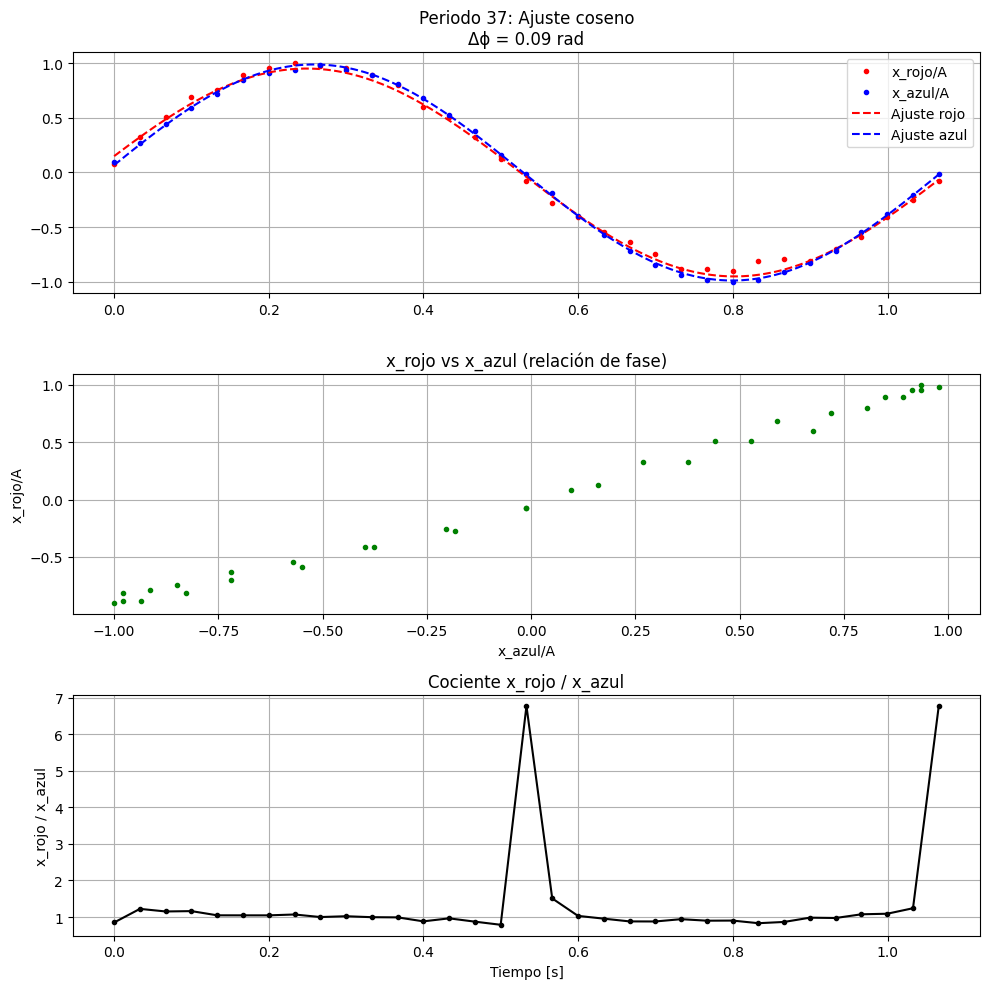

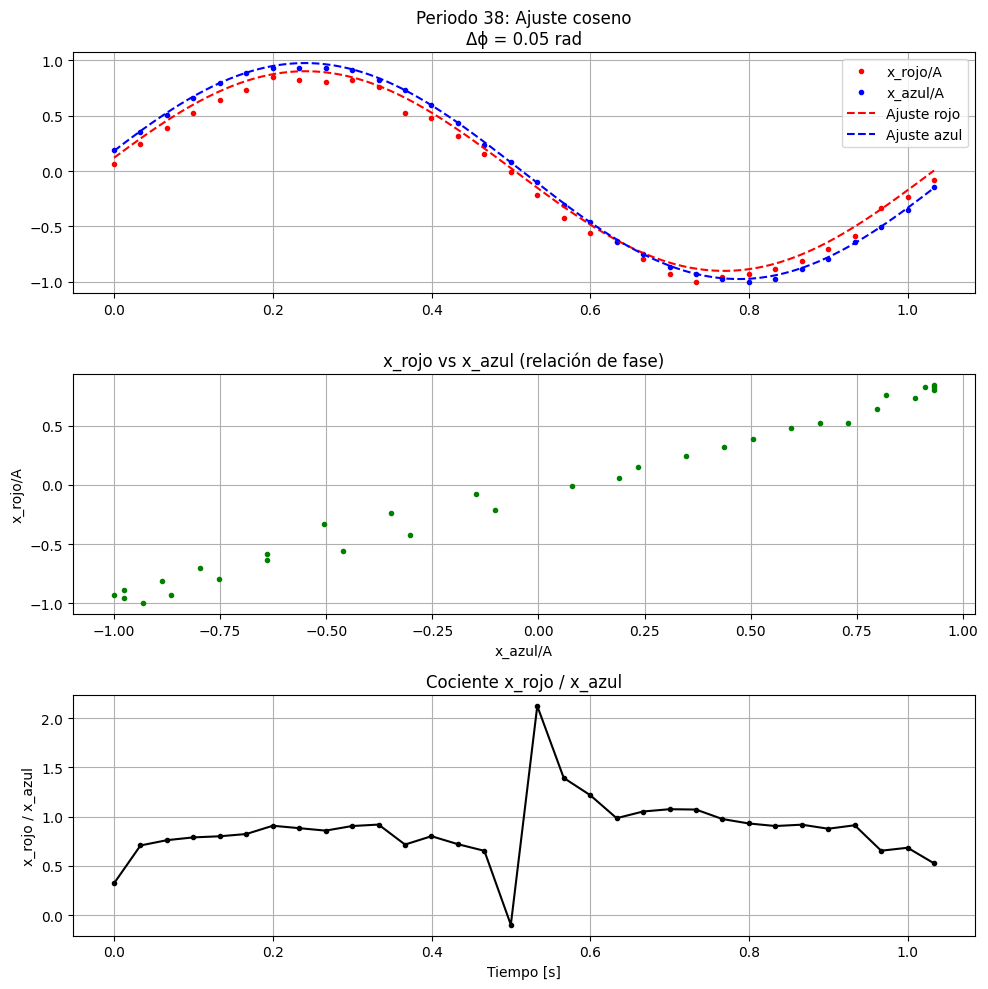

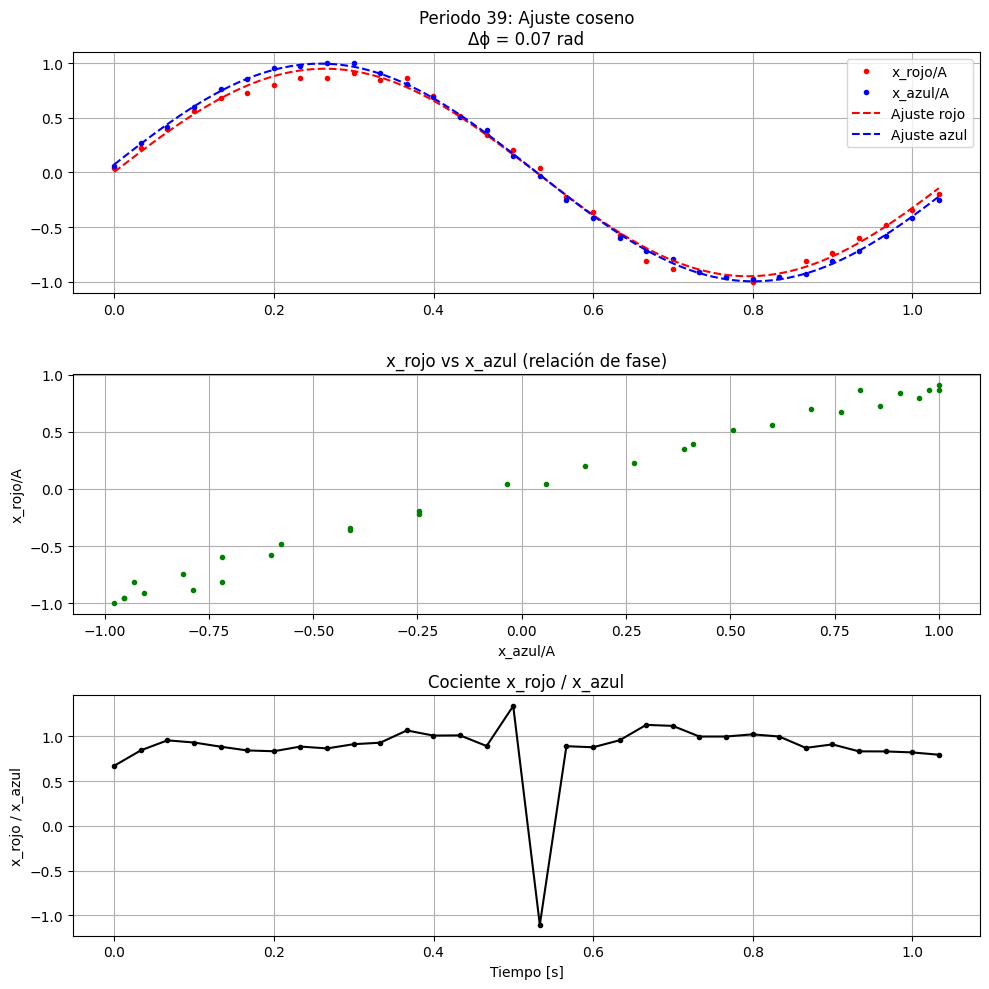

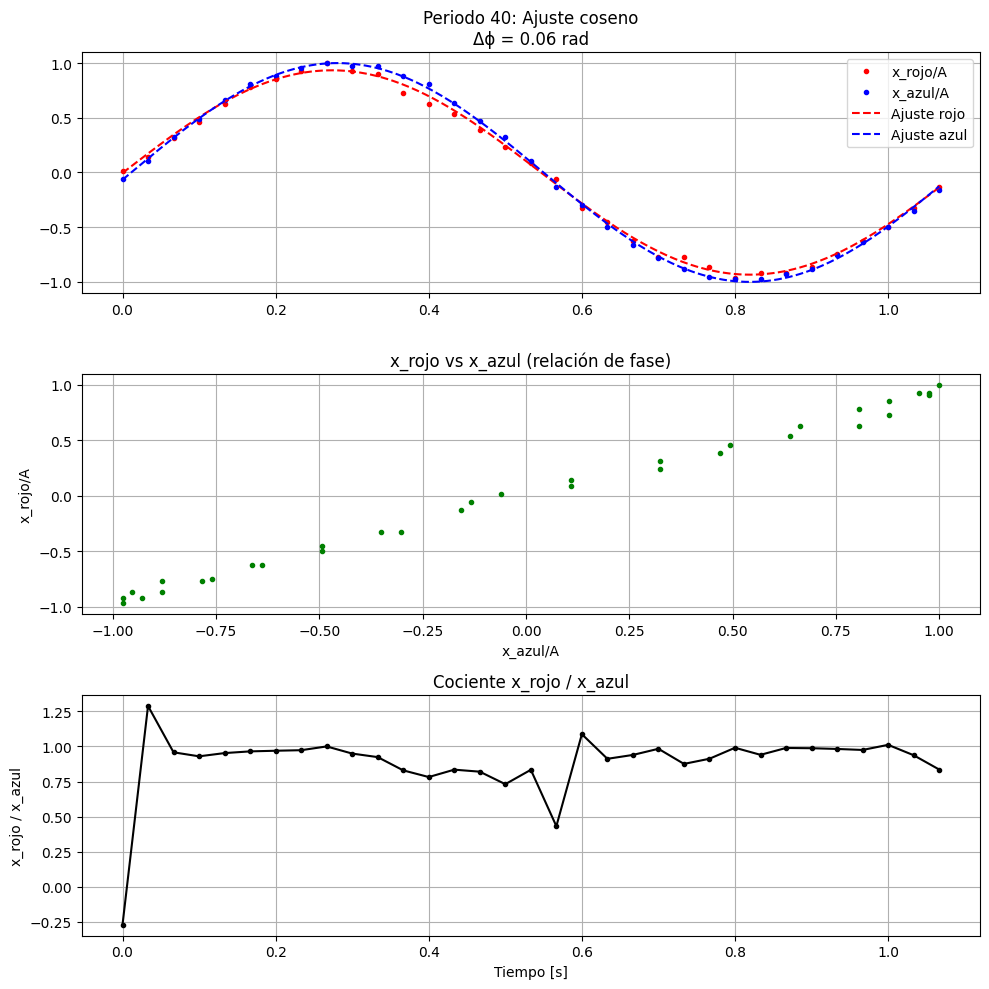

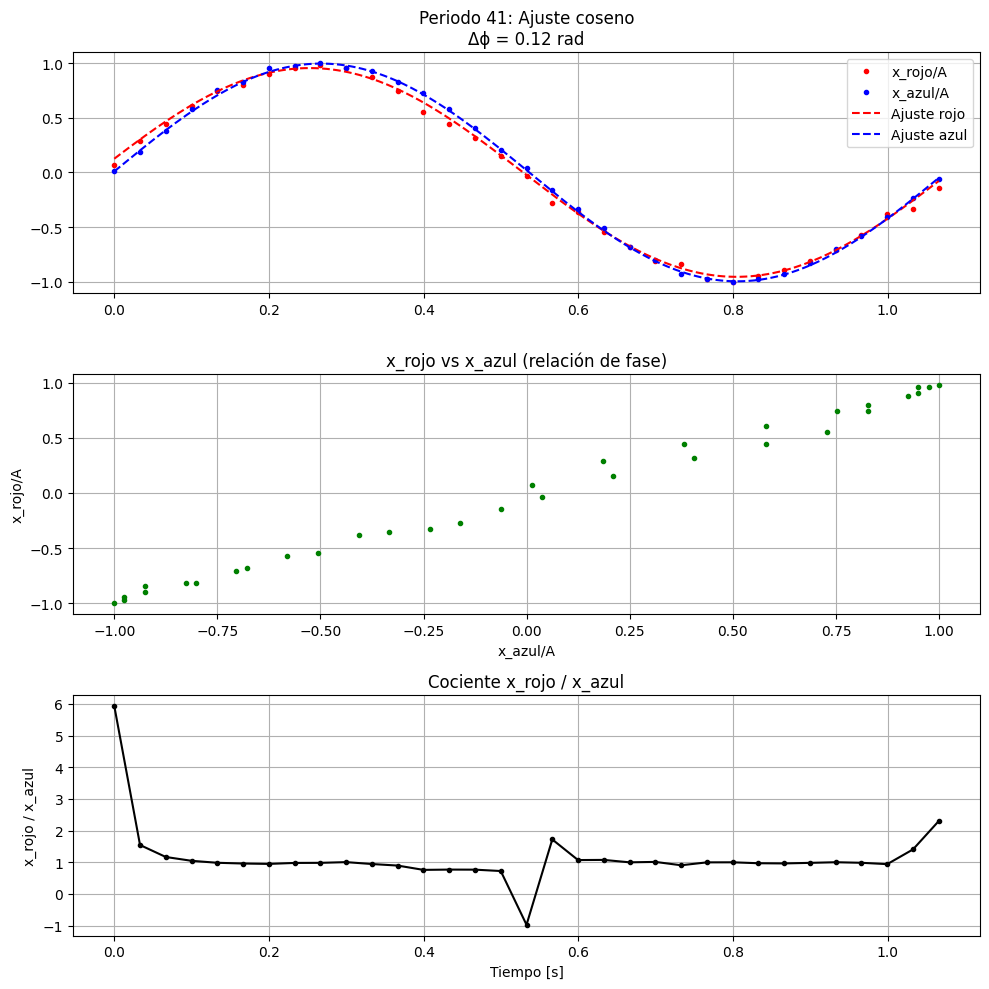

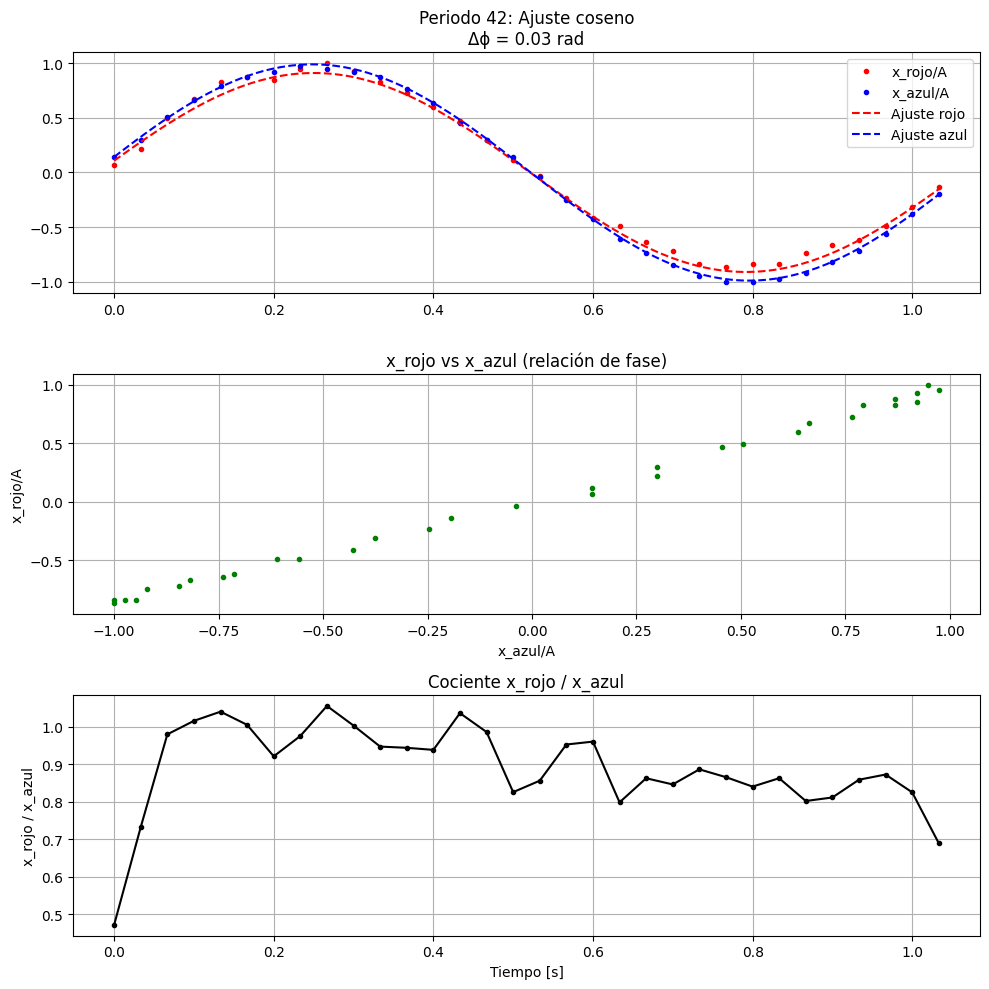

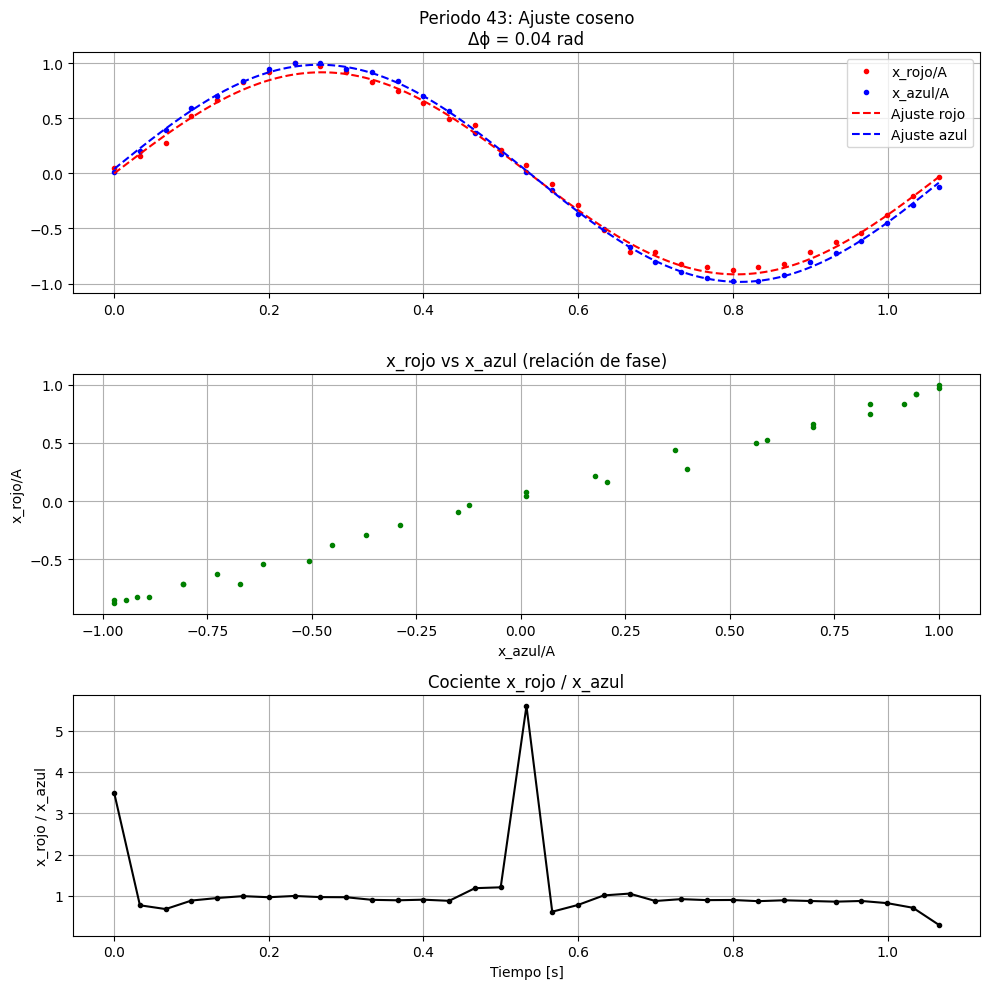

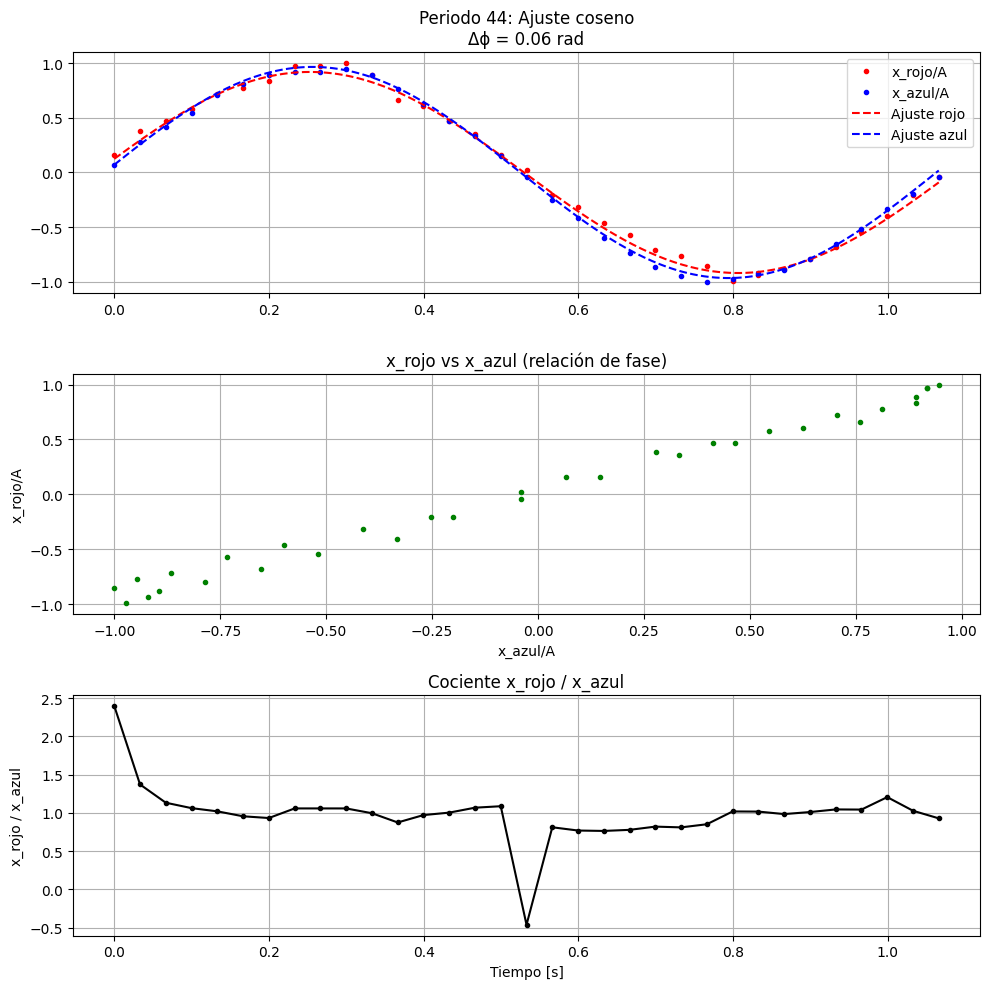

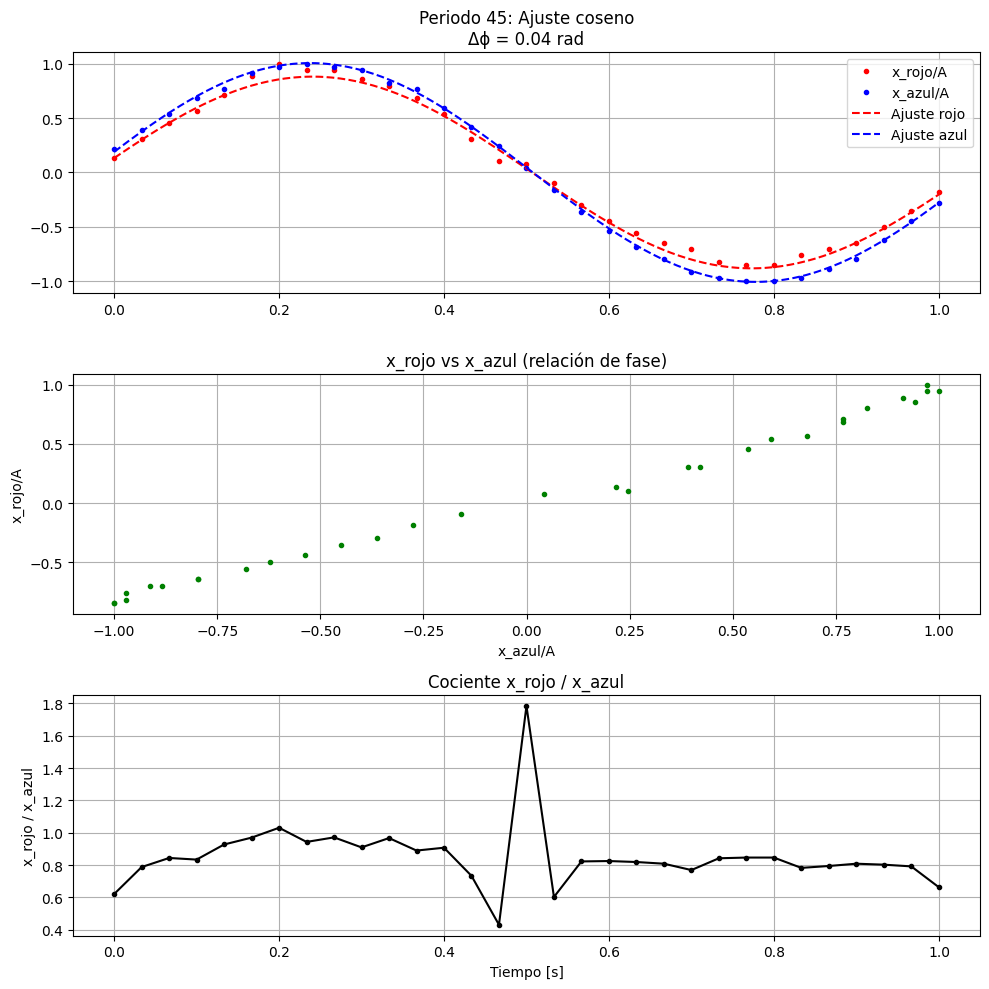

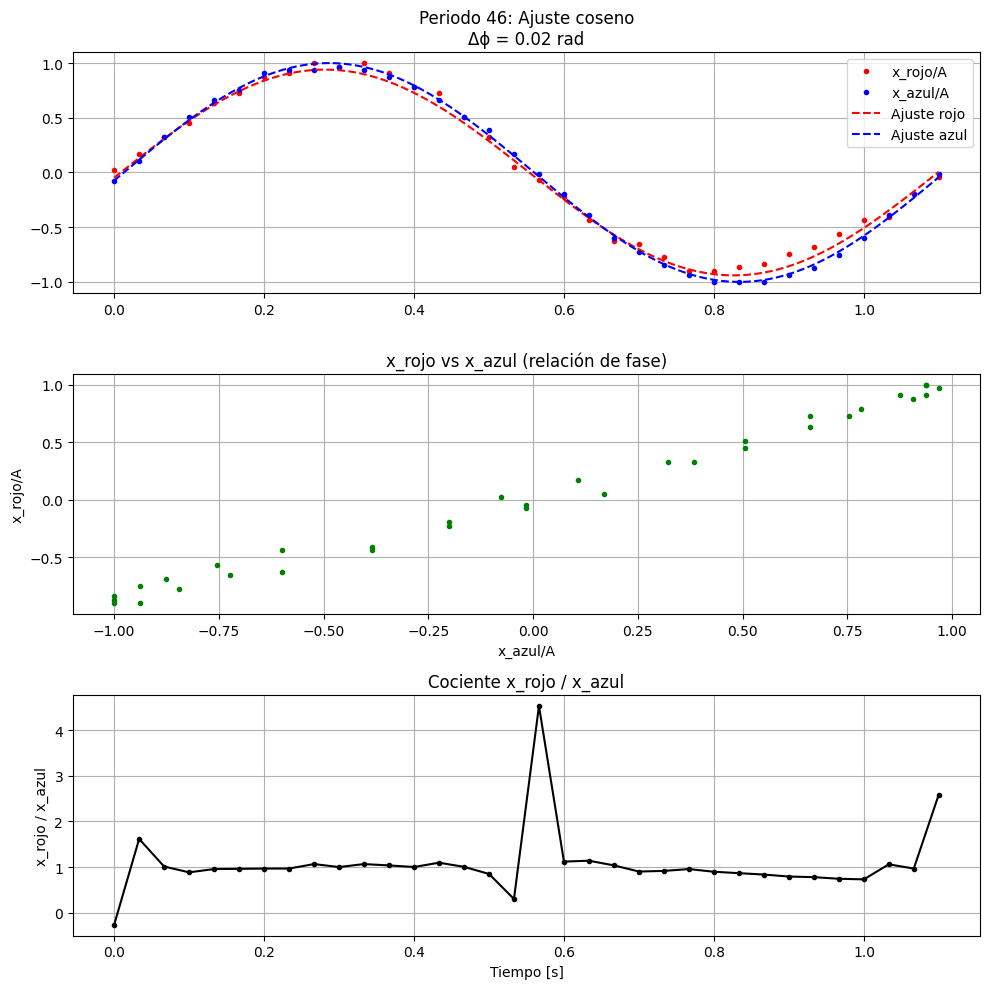

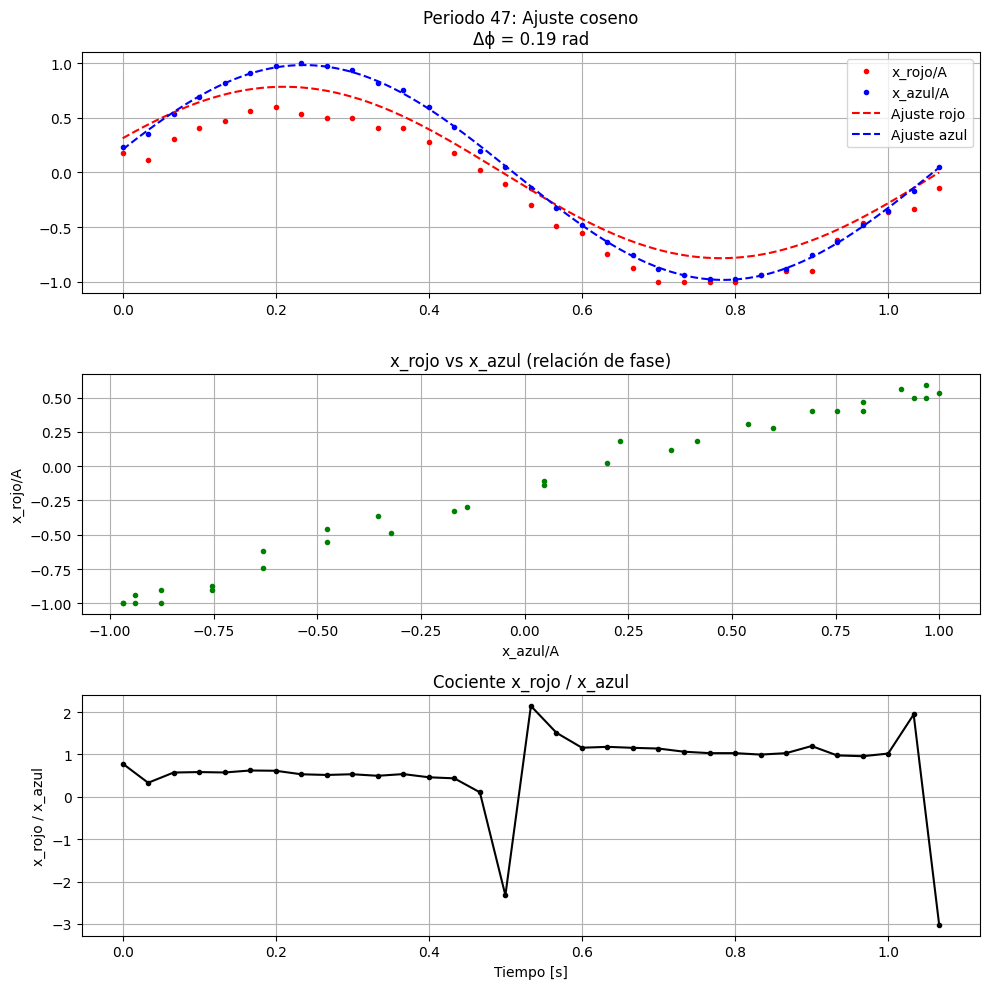

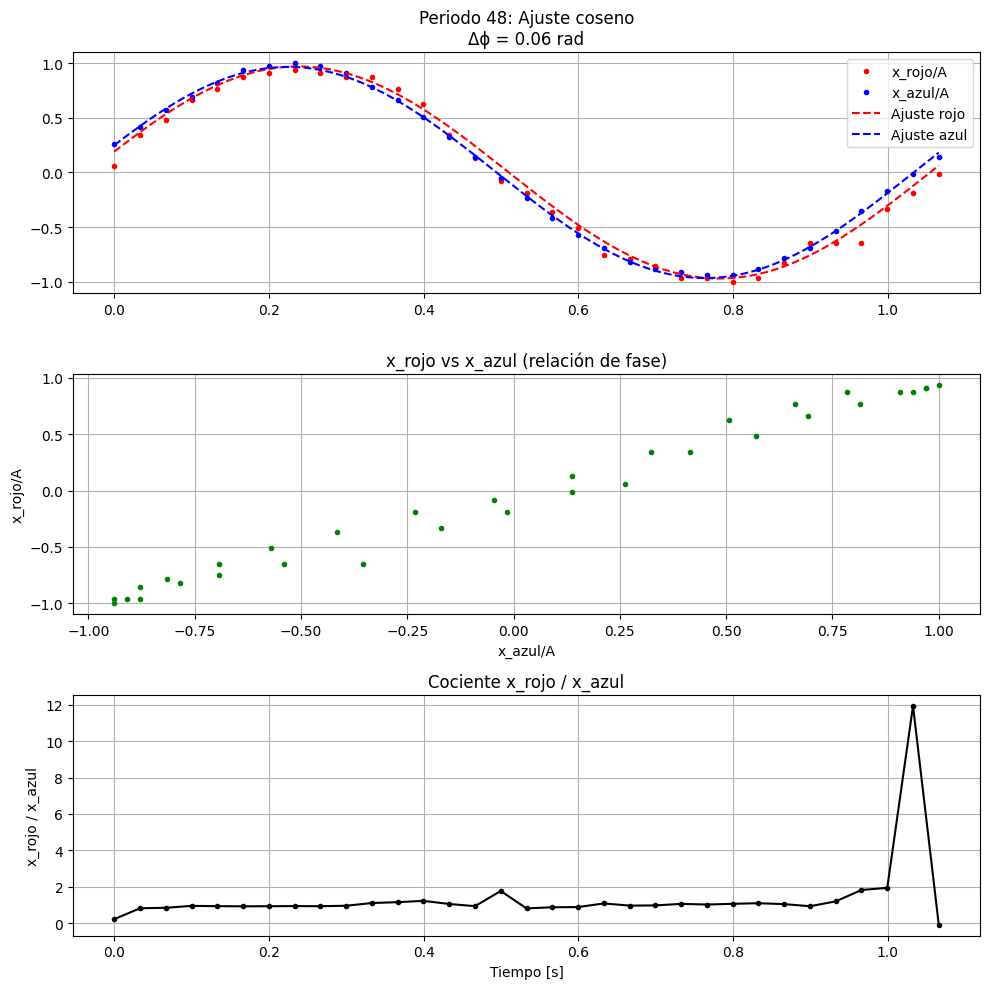

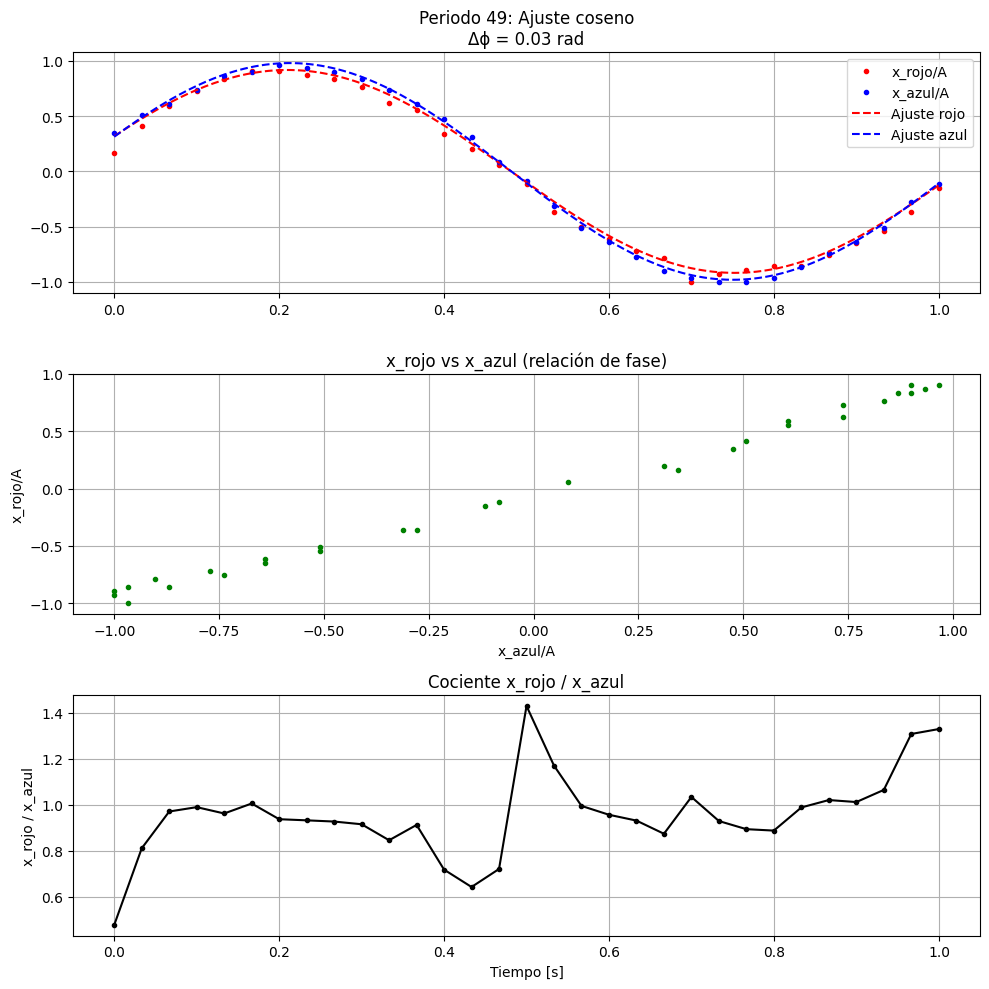

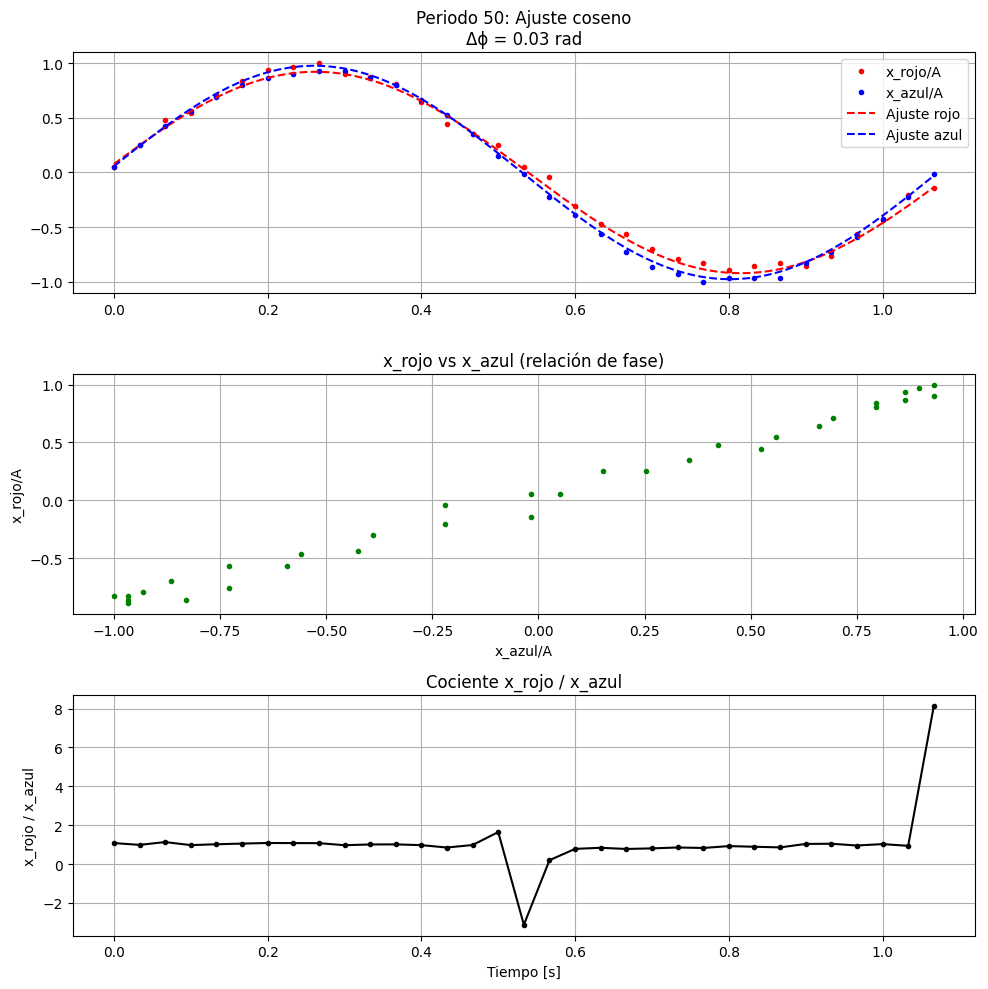

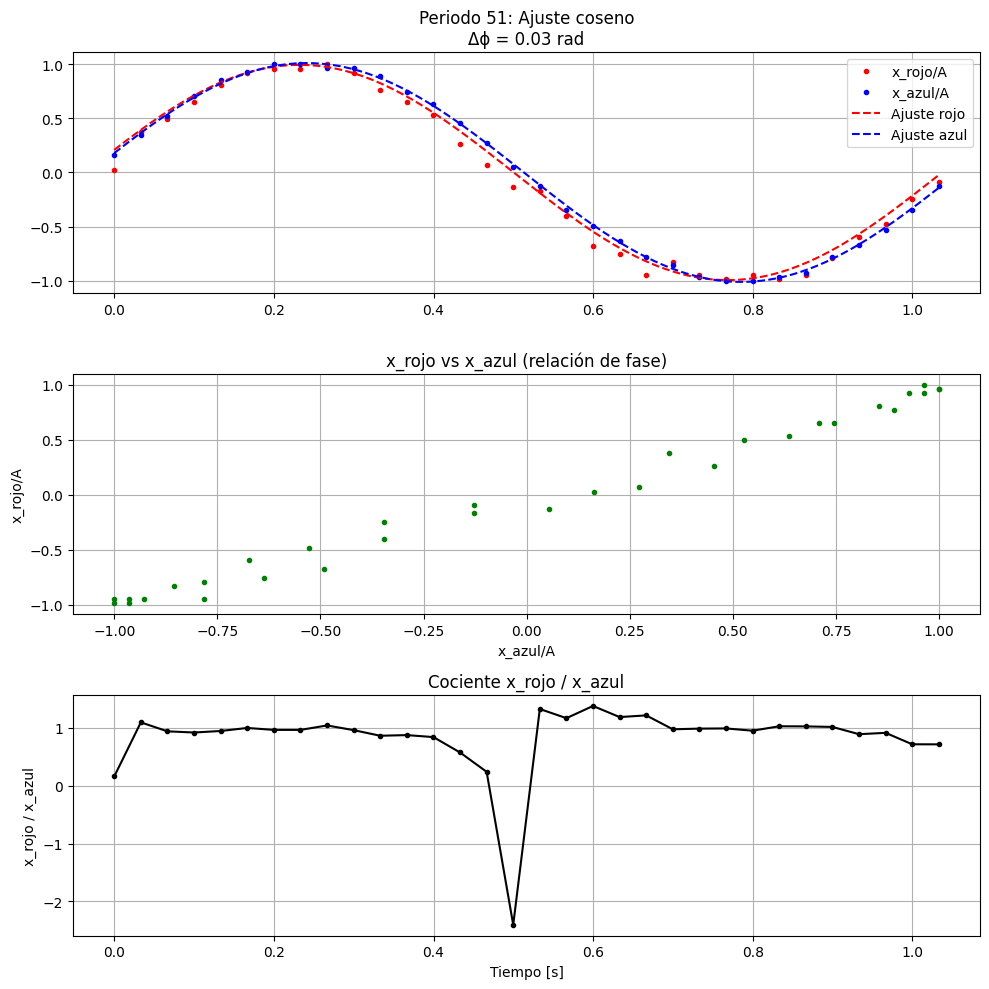

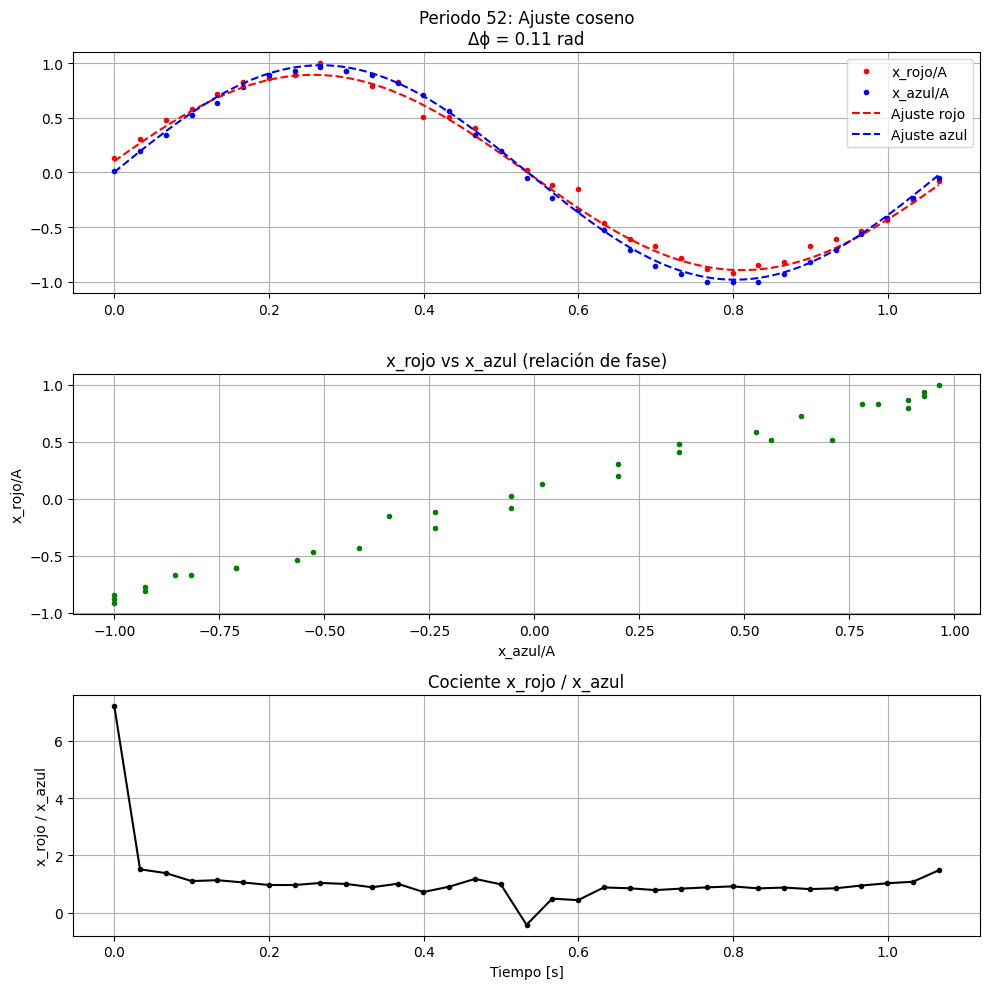

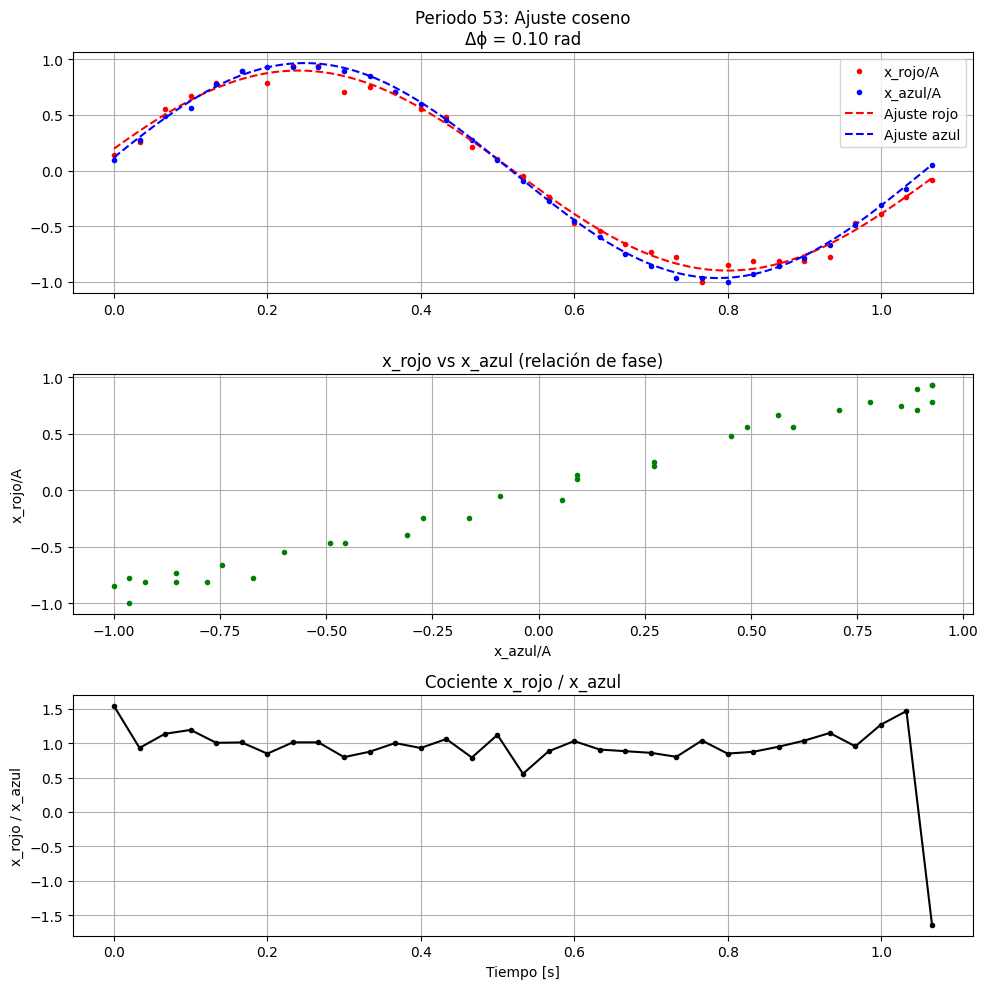

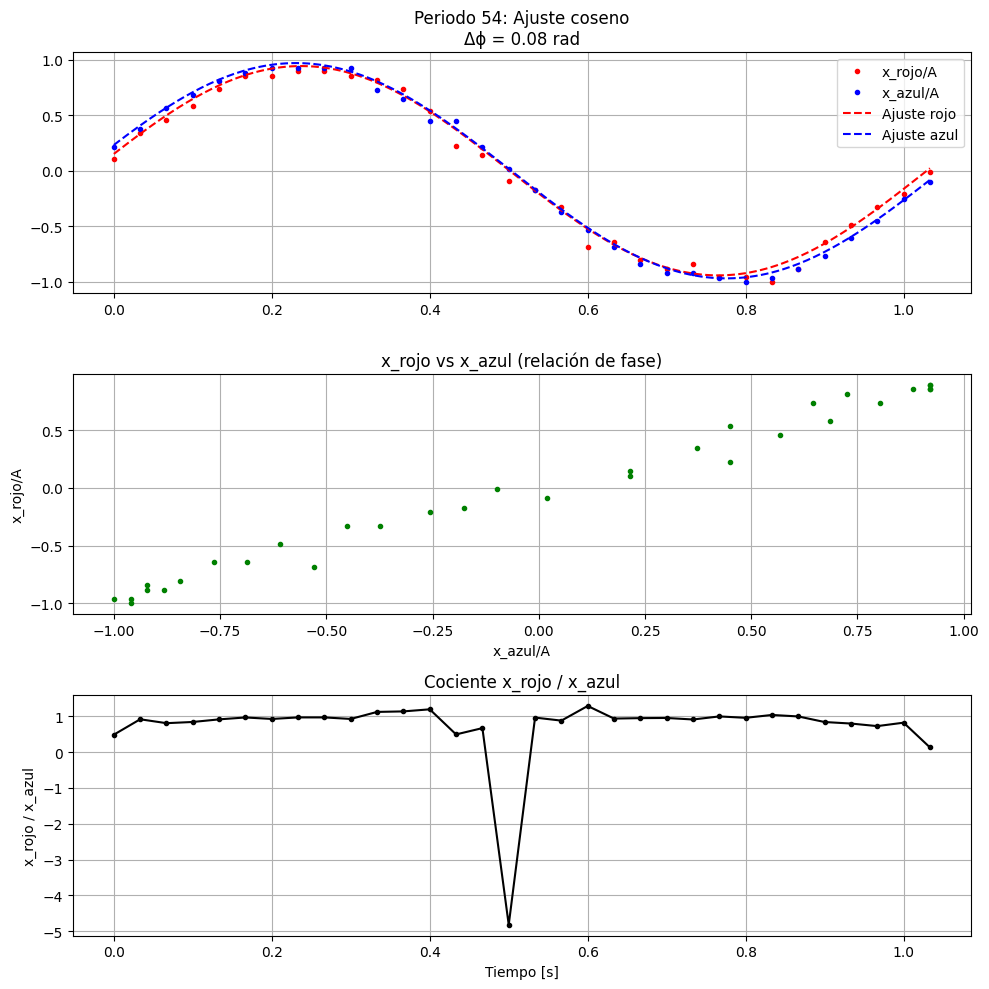

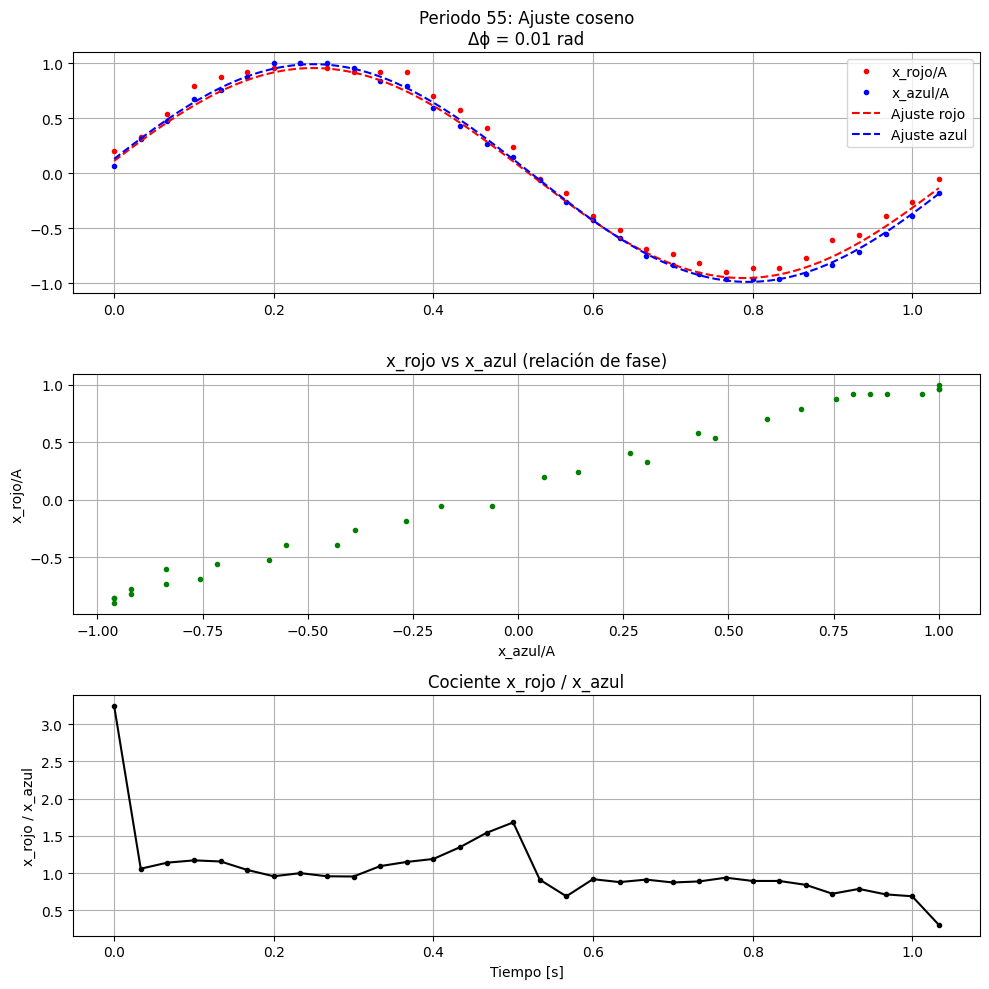

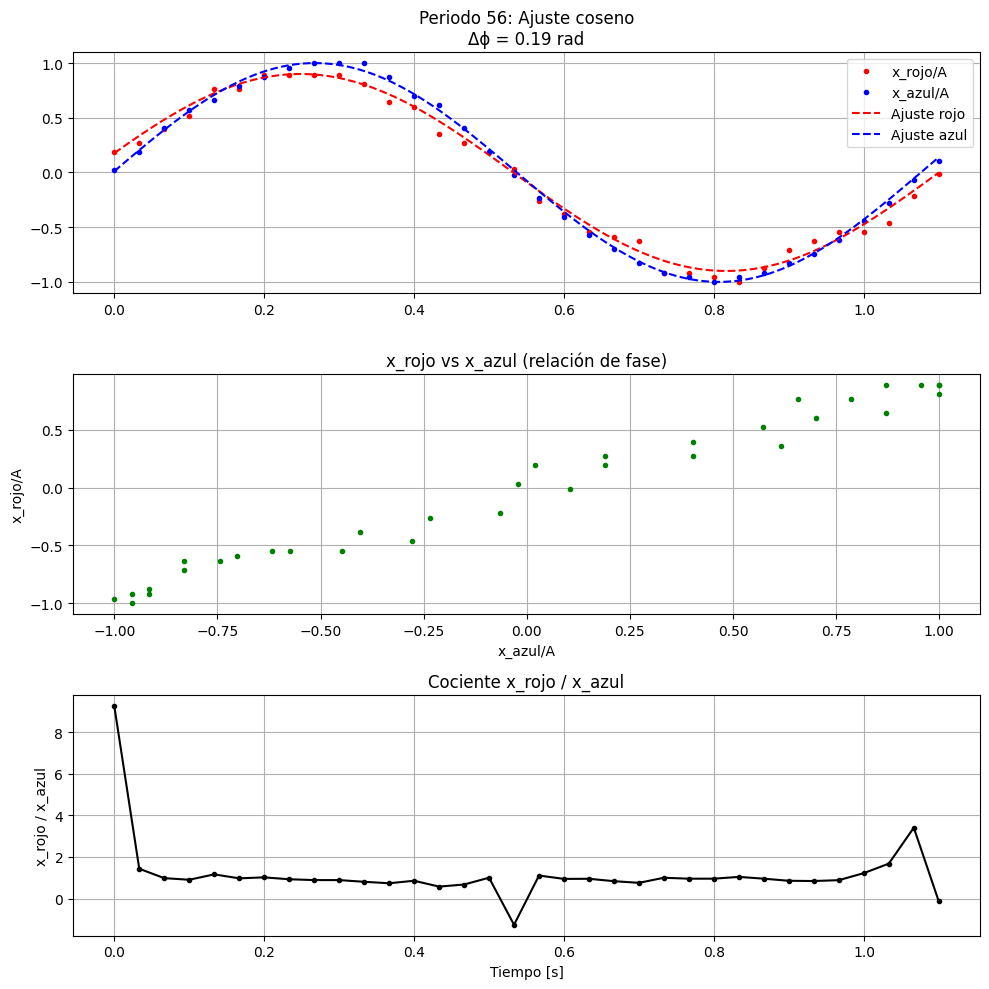

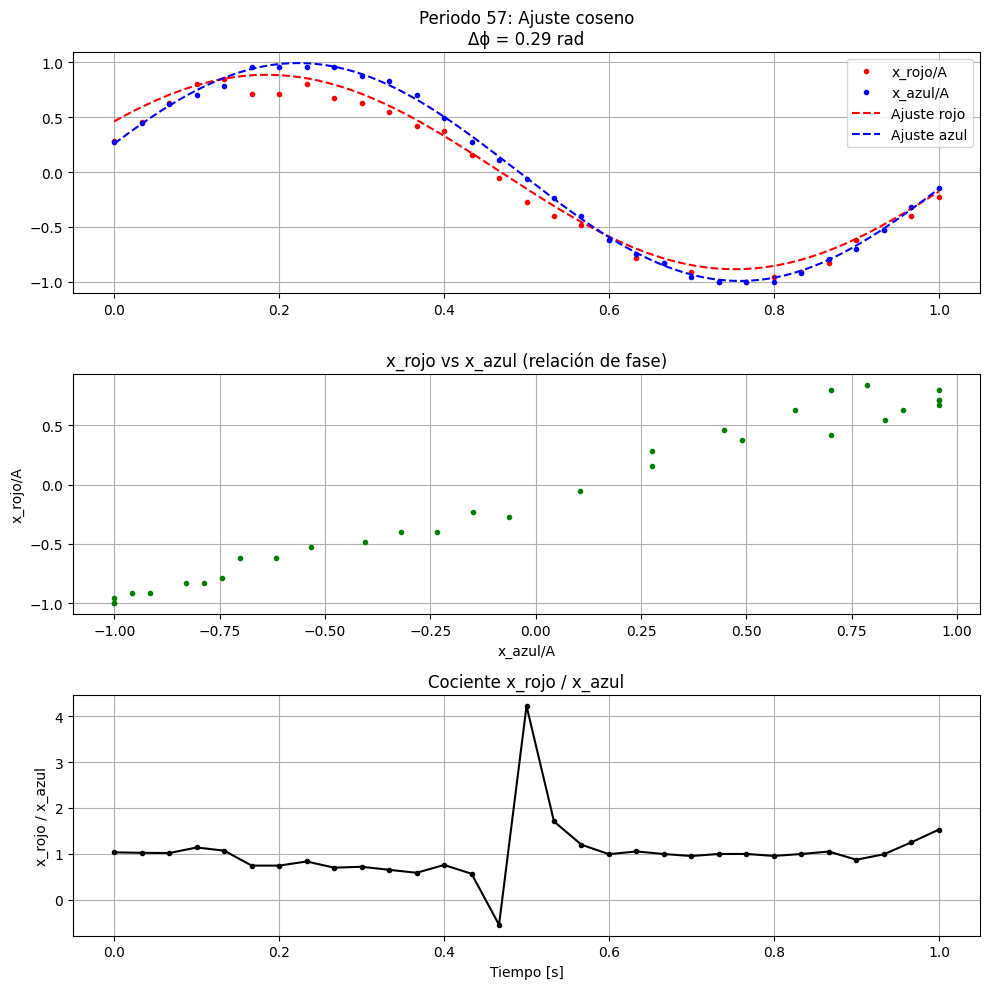

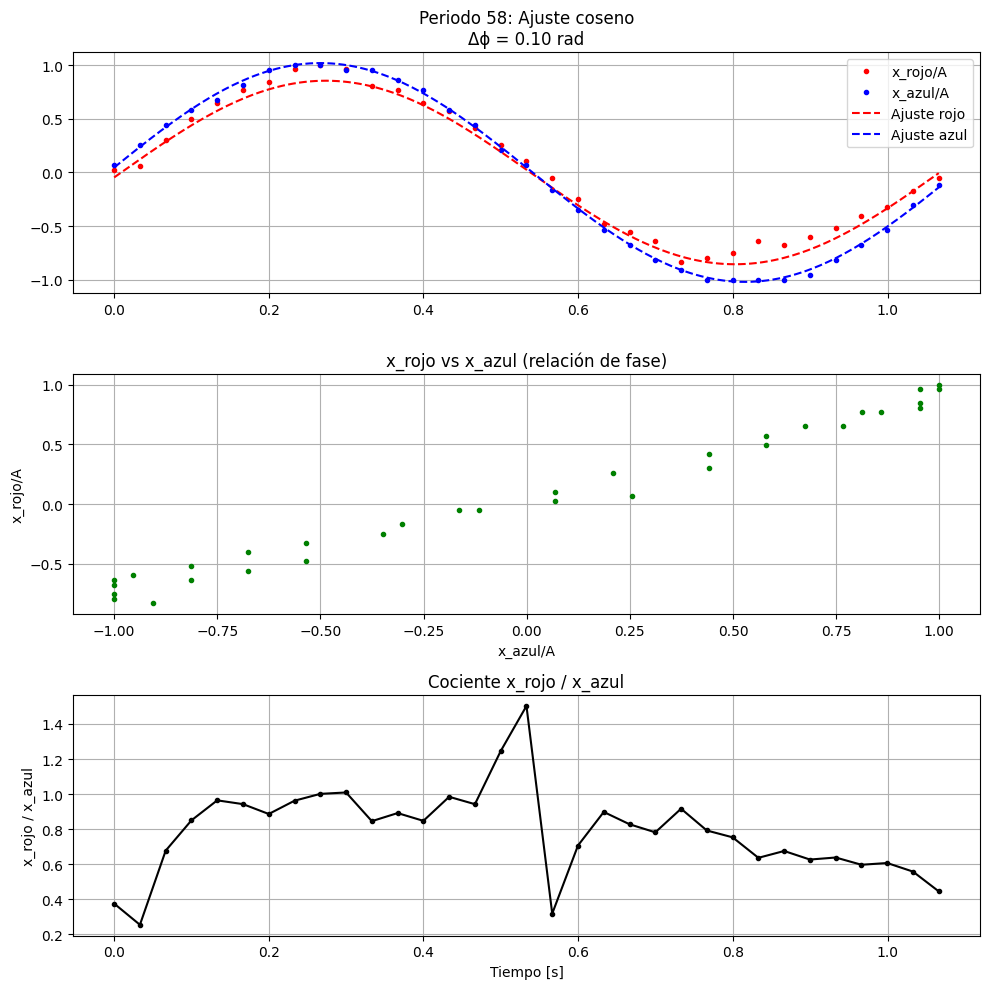

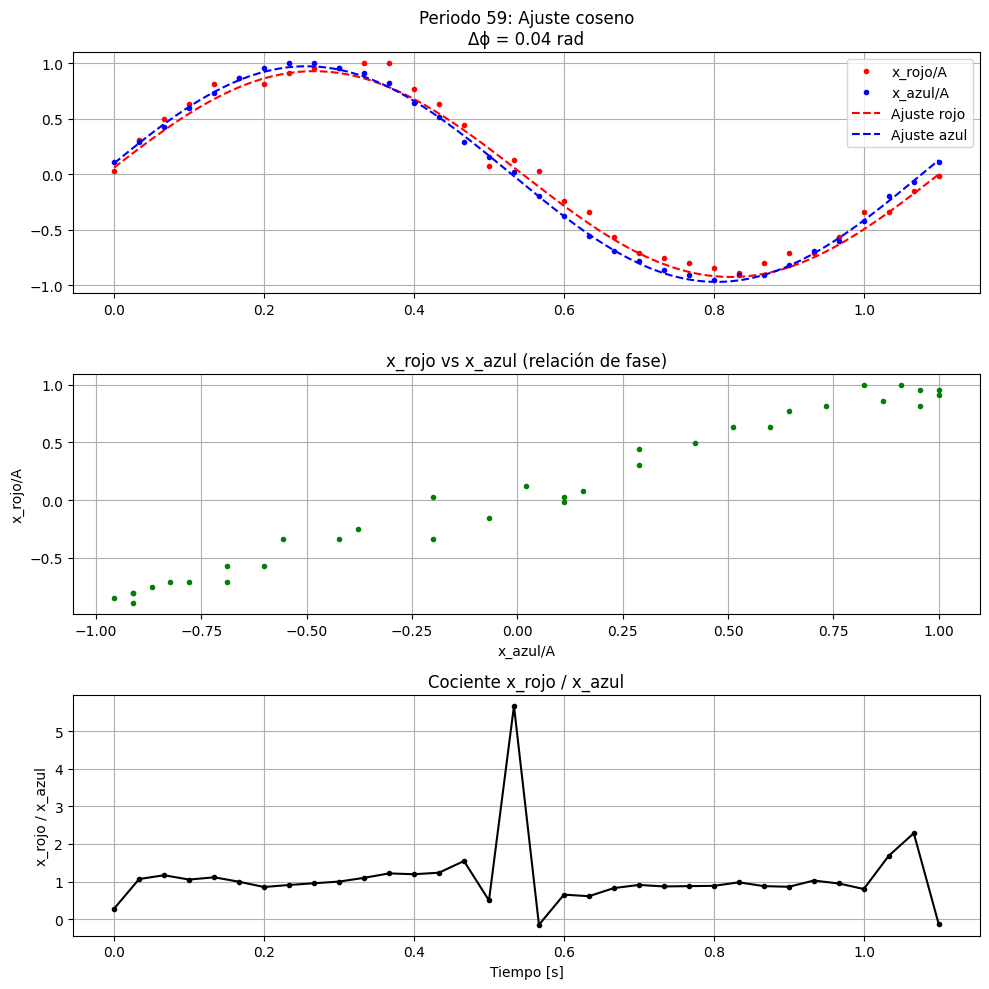

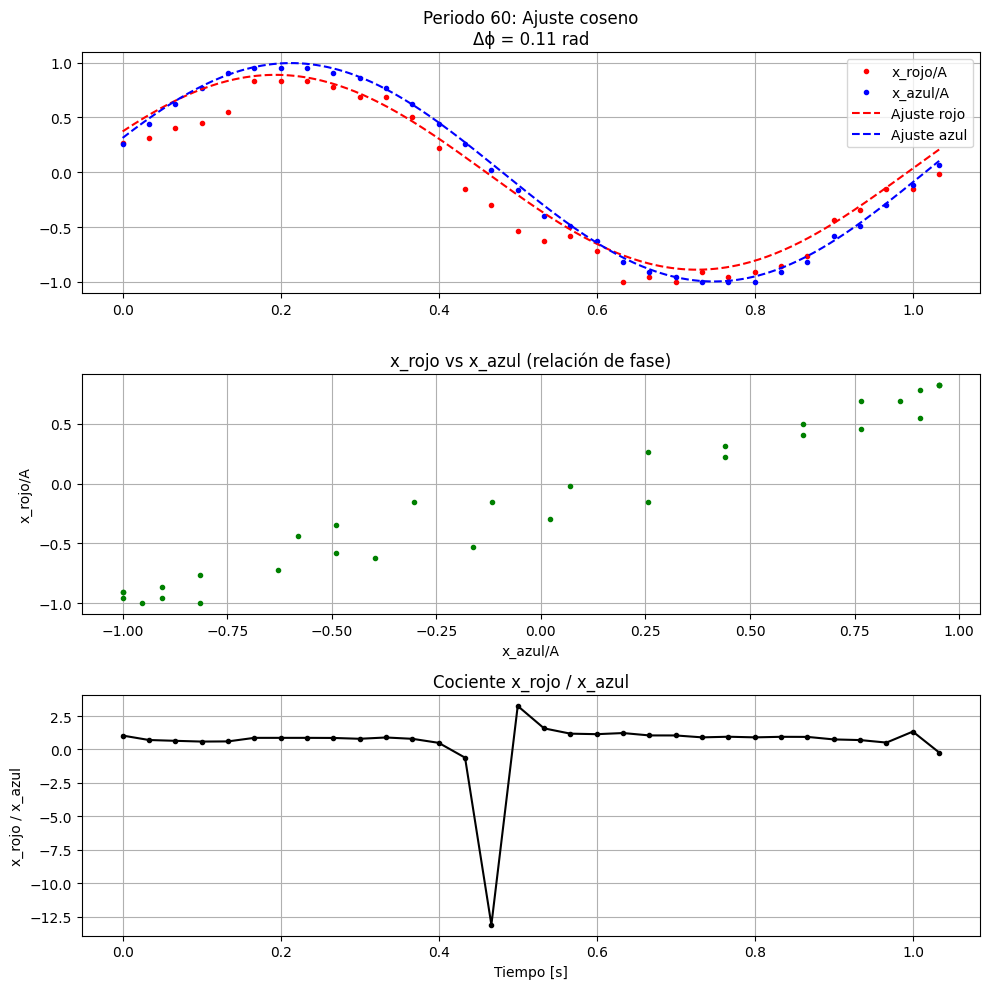

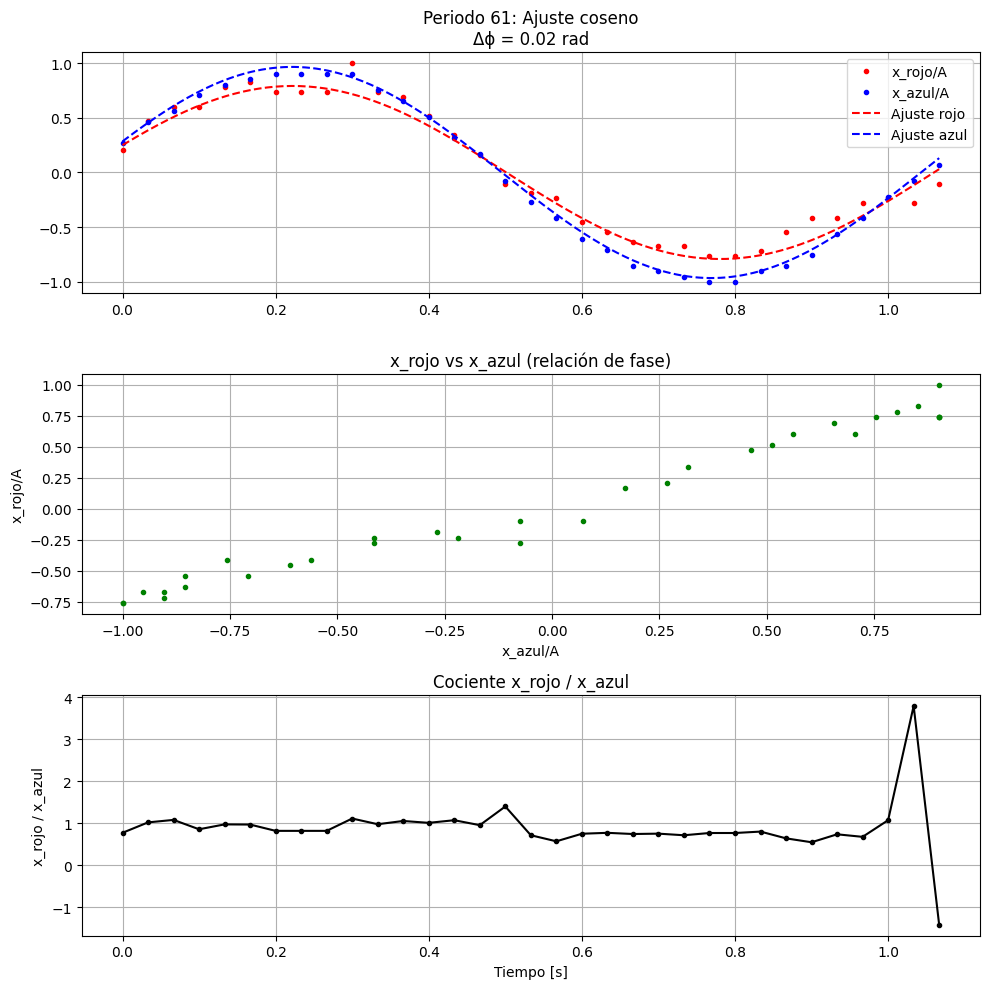

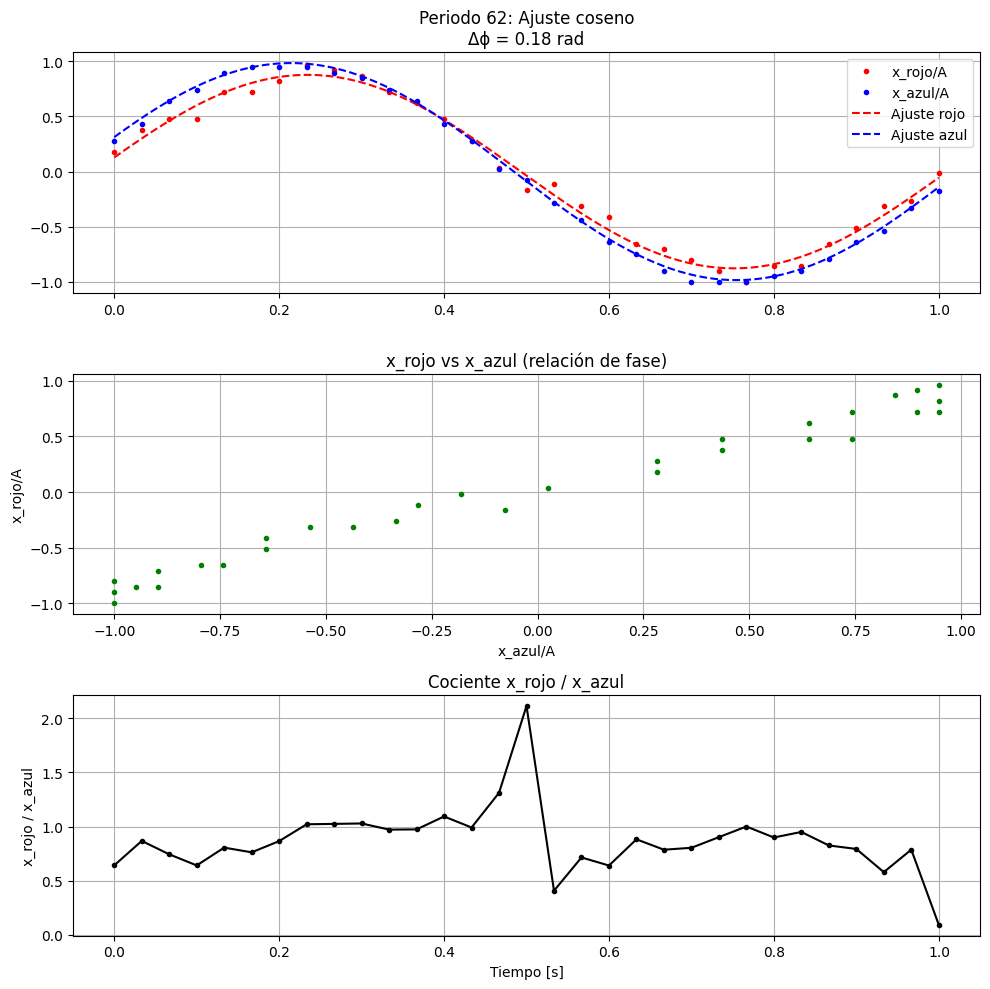

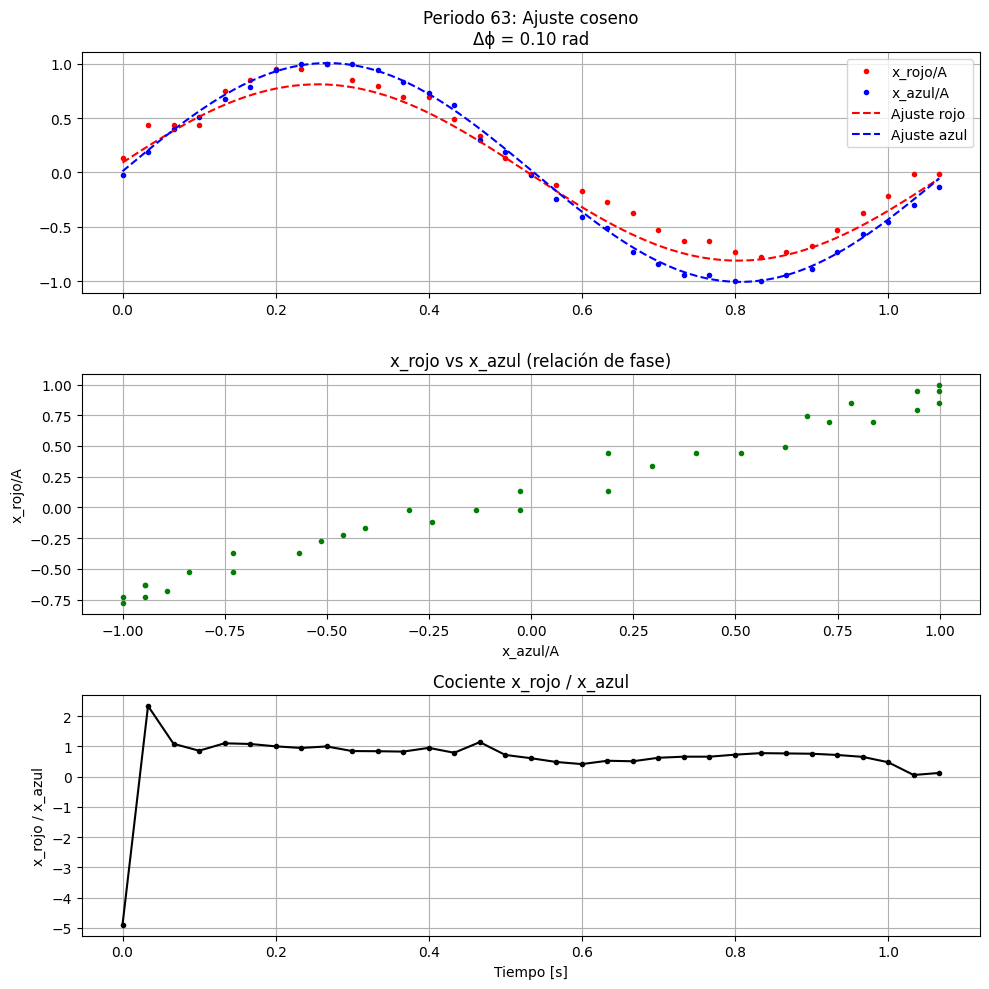

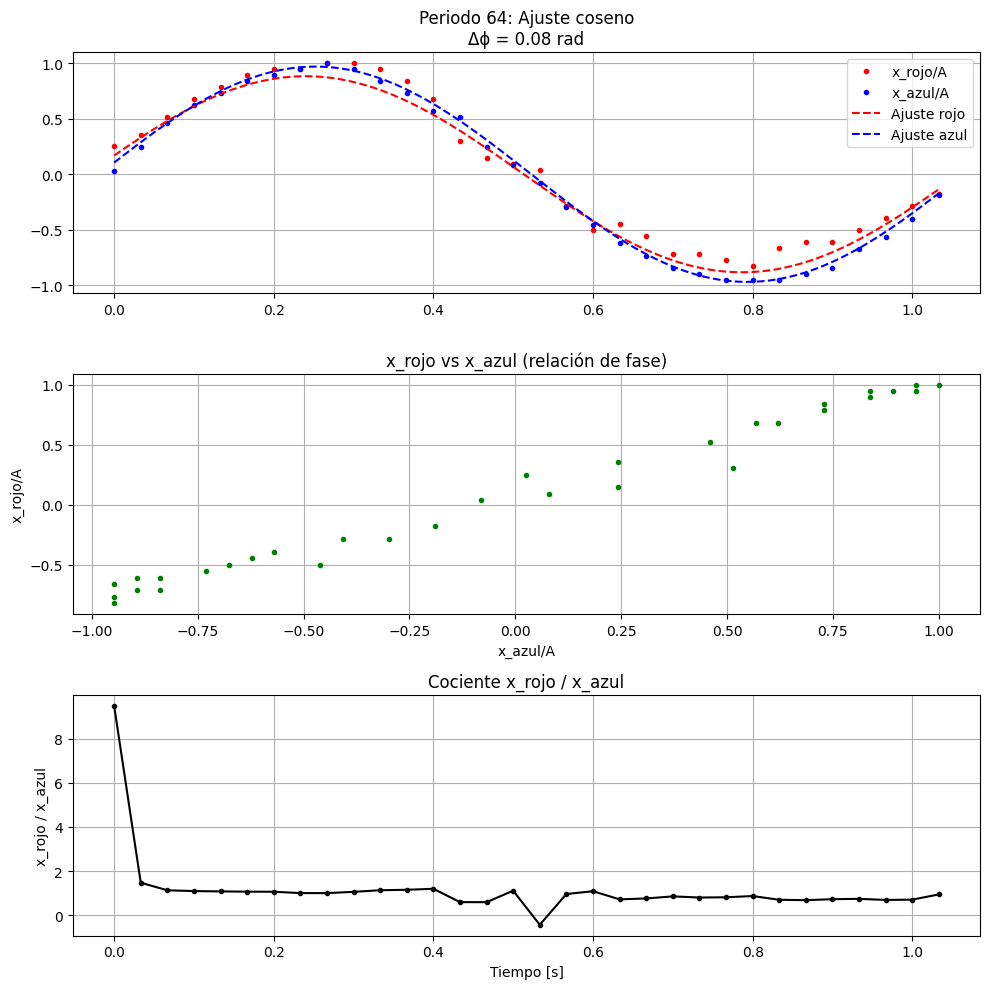


=== Frecuencias teóricas ===
Modo 1: ω = 14.756 rad/s  ->  f = 2.348 Hz
Modo 2: ω = 25.144 rad/s  ->  f = 4.002 Hz


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.linalg import eigh

# === 1. Cargar datos ===
ruta_csv = '/Users/admin/Documents/Fisica experimental/Experimento-Modos-Normales-de-Oscilacion/MasasIgualesPlasticosaModoLento/trayectorias.csv'
df = pd.read_csv(ruta_csv)

# === 2. Centrar señales ===
df['x_rojo_c'] = df['x_rojo'] - df['x_rojo'].mean()
df['x_azul_c'] = df['x_azul'] - df['x_azul'].mean()

t = df['tiempo_s'].values
x1 = df['x_rojo_c'].values
x2 = df['x_azul_c'].values

# === 3. Detección de cruces por cero positivos ===
def cruces_cero_positivos(x, t):
    cruces = []
    for i in range(1, len(x)):
        if x[i-1] < 0 and x[i] >= 0:
            t0 = t[i-1] + (0 - x[i-1]) * (t[i] - t[i-1]) / (x[i] - x[i-1])
            cruces.append((i, t0))
    return cruces

cruces = cruces_cero_positivos(x1, t)

# === 4. Extraer periodos válidos ===
periodos = []
for i in range(len(cruces)-1):
    i_ini = cruces[i][0]
    i_fin = cruces[i+1][0]
    t_p = t[i_ini:i_fin] - t[i_ini]
    x1_p = x1[i_ini:i_fin]
    x2_p = x2[i_ini:i_fin]
    
    A1 = np.max(np.abs(x1_p))
    A2 = np.max(np.abs(x2_p))
    
    if A1 > 0 and A2 > 0:
        x1_p_norm = x1_p / A1
        x2_p_norm = x2_p / A2

        # Verificar que no haya NaNs o infs
        if not (np.any(np.isnan(x1_p_norm)) or np.any(np.isnan(x2_p_norm)) or
                np.any(np.isinf(x1_p_norm)) or np.any(np.isinf(x2_p_norm))):
            periodos.append((t_p, x1_p_norm, x2_p_norm))
        else:
            print(f"Periodo {i+1} descartado por NaN o inf")
    else:
        print(f"Periodo {i+1} descartado por amplitud cero")

# === 5. Modelo coseno ===
def modelo_coseno(t, A, w, phi):
    return A * np.cos(w * t + phi)

# === 6. Ajustar cada periodo ===
for i, (t_p, x1_p, x2_p) in enumerate(periodos):
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    # Estimación inicial de omega
    T_estimado = t_p[-1] - t_p[0]
    p0 = [1, 2*np.pi / T_estimado, 0]

    try:
        popt1, _ = curve_fit(modelo_coseno, t_p, x1_p, p0=p0)
        popt2, _ = curve_fit(modelo_coseno, t_p, x2_p, p0=p0)
    except RuntimeError:
        print(f"Ajuste fallido en periodo {i+1}")
        continue

    A1, w1, phi1 = popt1
    A2, w2, phi2 = popt2

    # Gráfica 1: señales y ajustes
    t_fit = np.linspace(t_p.min(), t_p.max(), 300)
    axs[0].plot(t_p, x1_p, 'r.', label='x_rojo/A')
    axs[0].plot(t_p, x2_p, 'b.', label='x_azul/A')
    axs[0].plot(t_fit, modelo_coseno(t_fit, *popt1), 'r--', label='Ajuste rojo')
    axs[0].plot(t_fit, modelo_coseno(t_fit, *popt2), 'b--', label='Ajuste azul')
    axs[0].set_title(f'Periodo {i+1}: Ajuste coseno\nΔϕ = {np.abs(phi1 - phi2):.2f} rad')
    axs[0].legend()
    axs[0].grid(True)

    # Gráfica 2: x1 vs x2
    axs[1].plot(x2_p, x1_p, 'g.')
    axs[1].set_title('x_rojo vs x_azul (relación de fase)')
    axs[1].set_xlabel('x_azul/A')
    axs[1].set_ylabel('x_rojo/A')
    axs[1].grid(True)

    # Gráfica 3: cociente x1/x2
    razon = x1_p / x2_p
    axs[2].plot(t_p, razon, 'k.-')
    axs[2].set_title('Cociente x_rojo / x_azul')
    axs[2].set_xlabel('Tiempo [s]')
    axs[2].set_ylabel('x_rojo / x_azul')
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

# === 7. Frecuencias teóricas ===
m1 = 0.2993  # kg
m2 = 0.2986  # kg
k1 = 67.9    # N/m
k2 = 61.9    # N/m
k3 = 62.4    # N/m

K = np.array([[k1 + k2, -k2],
              [-k2, k2 + k3]])
M = np.array([[m1, 0],
              [0, m2]])

w2, vecs = eigh(K, M)
omega_teo = np.sqrt(w2)
frecuencias_Hz = omega_teo / (2 * np.pi)

print("\n=== Frecuencias teóricas ===")
for i, w in enumerate(omega_teo):
    print(f"Modo {i+1}: ω = {w:.3f} rad/s  ->  f = {frecuencias_Hz[i]:.3f} Hz")
